This notebook seeks to explore the gender diversity of the different apache projects & the process

In [3]:
import os

In [4]:
# Kind of a hack because of the Spark notebook serialization issues
!rm lazy_helpers.py*
!wget https://raw.githubusercontent.com/holdenk/diversity-analytics/master/lazy_helpers.py

--2019-06-18 09:26:18--  https://raw.githubusercontent.com/holdenk/diversity-analytics/master/lazy_helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1397 (1.4K) [text/plain]
Saving to: ‘lazy_helpers.py’

lazy_helpers.py     100%[===================>]   1.36K  --.-KB/s    in 0s      

2019-06-18 09:26:19 (43.7 MB/s) - ‘lazy_helpers.py’ saved [1397/1397]



In [5]:
os.environ["PYSPARK_PYTHON"] = "/opt/conda/bin/python"
os.environ["PYSPARK_DRIVER_PYTHON"] = "/opt/conda/bin/python"

In [6]:
!/opt/conda/bin/python --version

Python 3.6.3 :: Anaconda, Inc.


In [7]:
import sys
print(sys.version)

3.6.3 |Anaconda, Inc.| (default, Nov 20 2017, 20:41:42) 
[GCC 7.2.0]


In [8]:
from pyspark import *
from pyspark.sql import *
from pyspark.sql.session import SparkSession
import matplotlib.pyplot as plt

In [9]:
EXECS = 17

In [10]:
session = SparkSession.builder.master("yarn").config("spark.executor.instances", EXECS).config("spark.pyspark.python", "/opt/conda/bin/python").getOrCreate()

In [11]:
session

In [232]:
#Hack to update sparklingml on a running cluster -
#TODO(holden): release sparkling ml properly so no hacks
memory_status_count = sc._jsc.sc().getExecutorMemoryStatus().size()
estimated_executors = max(sc.defaultParallelism, memory_status_count)
rdd = sc.parallelize(range(estimated_executors))
def do_update(x):
    import os
    return str(os.popen("whoami && cd / && cd /sparklingml || git clone https://github.com/sparklingpandas/sparklingml.git && git pull && git log -n 5 && pip install -e . || true").read())
result = rdd.map(do_update)
result.collect()

['yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n',
 'yarn\n']

In [13]:
import os
os.environ['PATH'] = os.environ['PATH'] + ":/usr/lib/chromium/"

In [14]:
from pyspark import *
from pyspark.sql import *
from pyspark.sql.functions import concat, collect_set, explode, from_json, format_string
from pyspark.sql import functions as F
from pyspark.sql.session import *
from pyspark.sql.types import *

import json
import os
# import meetup.api
from copy import copy
import time
import logging
import subprocess
import matplotlib.pyplot as plt

API key configuration

In [15]:
# Load gh_api_token & meetup_key & genderize_key
exec(open("./secrets.literal").read())
gh_user = "holdenk"
fs_prefix = "gs://boo-stuff/"

Less secret configuration

In [16]:
max_meetup_events = 800

In [17]:
SparkSession.builder.getOrCreate().stop()

In [18]:
session = (SparkSession.builder
           .appName("whatCanWeLearnFromTheSixties")
           #.config("spark.executor.instances", "45")
           .config("spark.executor.instances", EXECS)
           .config("spark.driver.memoryOverhead", "0.25")
           #.config("spark.executor.memory", "16g")
           .config("spark.executor.memory", "16g")
           .config("spark.dynamicAllocation.enabled", "false")
           .config("spark.ui.enabled", "true")
           .config("spark.sql.catalogImplementation", "hive")
          ).getOrCreate()
sc = session.sparkContext

In [19]:
sc.parallelize(range(10)).collect()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [20]:
# In _theory_ in preview dataproc Spark UI is force disabled but history fills the gap, except history server isn't started by default :(
sc.getConf().get("spark.yarn.historyServer.address")

'holden-magic-m:18080'

The first thing we want to get is the committers and PMC members, this information is stored in LDAP but also available in JSON. Eventually we will want to enrich this with mailing list information

In [21]:
def loadFlatJsonFile(path, explodeKey, schema=None):
    """Load a flat multi-line json file and convert into Spark & explode"""
    rdd = sc.wholeTextFiles(path).values().setName("Input file {}".format(path))
    df = (session.read.schema(schema)
            .json(rdd))
    return df.select(explode(explodeKey))

In [22]:
apache_people_schema = StructType([StructField("lastCreateTimestamp", StringType()),
                     StructField("people",
                                 MapType(StringType(), 
                                         StructType([StructField('name', StringType()),
                                                     StructField('key_fingerprints', ArrayType(StringType())),
                                                     StructField('urls', ArrayType(StringType())),
                                                    ]))
                                )])
apache_poeple_df_file = "{0}{1}".format(fs_prefix, "http_data_sources/public_ldap_people.json") # http://people.apache.org/public/public_ldap_people.json
apache_people_df = loadFlatJsonFile(path=apache_poeple_df_file, 
                                 explodeKey="people", schema=apache_people_schema)
apache_people_df = apache_people_df.select(apache_people_df.key.alias("username"), apache_people_df.value.alias("extra")).repartition(100).persist().alias("apache_people")
apache_people_df.alias("Apache Committers")

DataFrame[username: string, extra: struct<name:string,key_fingerprints:array<string>,urls:array<string>>]

In [23]:
sc.addFile("lazy_helpers.py")

In [24]:
# Construct a lazy urllib3 pool
from lazy_helpers import *
    
bcast_pool = sc.broadcast(LazyPool)
bcast_pool.value

lazy_helpers.LazyPool

In [25]:
def project_on_github(project):
    """Returns if a project is on github"""
    import urllib3
    http = bcast_pool.value.get()
    r = http.request('GET', "https://github.com/apache/{0}".format(project))
    return r.status == 200
session.catalog.registerFunction("on_github", project_on_github, BooleanType())
# Except I'm a bad person so....
from pyspark.sql.catalog import UserDefinedFunction
project_on_github_udf = UserDefinedFunction(project_on_github, BooleanType(), "on_github")
session.catalog._jsparkSession.udf().registerPython("on_github", project_on_github_udf._judf)

In [26]:
apache_committees_schema = StructType([StructField("lastCreateTimestamp", StringType()),
                     StructField("committees",
                                 MapType(StringType(), StructType([StructField('roster', ArrayType(StringType())),
                                                                  StructField('modifyTimestamp', StringType()),
                                                                  StructField('createTimestamp', StringType())
                                                                  ])))])
apache_committees_df_file = "{0}{1}".format(fs_prefix, "http_data_sources/public_ldap_committees.json") # http://people.apache.org/public/public_ldap_committees.json
apache_committees_df = loadFlatJsonFile(path=apache_committees_df_file,
                                 explodeKey="committees", schema=apache_committees_schema)
apache_committees_on_github_df = apache_committees_df.filter(project_on_github_udf(apache_committees_df.key))
apache_committees_on_github_df.persist(StorageLevel.MEMORY_AND_DISK)
committee_names_df = apache_committees_on_github_df.select(apache_committees_df.key.alias("project")).alias("apache_committees").repartition(200)
committee_names_df.persist(StorageLevel.MEMORY_AND_DISK)
committee_names_df.alias("Apache Committee Names")
committee_names_df.count()

163

In [27]:
project_to_user_df = apache_committees_on_github_df.select(
    apache_committees_on_github_df.key.alias("project"),
    explode(apache_committees_on_github_df.value.roster).alias("username"))


user_to_project_df = project_to_user_df.groupBy(project_to_user_df.username).agg(
    collect_set(project_to_user_df.project).alias("projects"))
apache_people_df = apache_people_df.join(user_to_project_df, on="username")
apache_people_df.alias("Apache People joined with projects")

DataFrame[username: string, extra: struct<name:string,key_fingerprints:array<string>,urls:array<string>>, projects: array<string>]

In [28]:
apache_people_df.take(1)

[Row(username='macdonst', extra=Row(name='Simon MacDonald', key_fingerprints=None, urls=None), projects=['cordova'])]

Attempt to fetch relevant past & present meetups for each project - idea based on the listing at https://www.apache.org/events/meetups.html but different code

We want to do a non-blocking count to materialize the meetup RDD because this is slow

In [29]:
# Some async helpers, in Scala we would use AsyncRDDActions but its not currently available in Python
# Support is being considered in https://issues.apache.org/jira/browse/SPARK-20347
def non_blocking_rdd_count(rdd):
    import threading
    def count_magic():
        rdd.count()
    thread = threading.Thread(target=count_magic)
    thread.start()

def non_blocking_rdd_save(rdd, target):
    import threading
    def save_panda():
        rdd.saveAsPickleFile(target)
    thread = threading.Thread(target=save_panda)
    thread.start()

def non_blocking_df_save(df, target):
    import threading
    def save_panda():
        df.write.mode("overwrite").save(target)
    thread = threading.Thread(target=save_panda)
    thread.start()

def non_blocking_df_save_csv(df, target):
    import threading
    def save_panda():
        df.write.format("csv").mode("overwrite") \
            .option("header", "true") \
            .option("quoteAll", "false") \
            .save(target)
    thread = threading.Thread(target=save_panda)
    thread.start()

def non_blocking_df_save_or_load(df, target):
    fs = sc._jvm.org.apache.hadoop.fs.FileSystem.get(sc._jvm.java.net.URI(fs_prefix), sc._jsc.hadoopConfiguration())
    success_files = ["{0}/SUCCESS.txt", "{0}/_SUCCESS"]
    if any(fs.exists(sc._jvm.org.apache.hadoop.fs.Path(t.format(target))) for t in success_files):
        print("Reusing")
        return session.read.option("format", "parquet").load(target).persist()
    else:
        print("Saving")
        non_blocking_df_save(df, target)
        return df

def non_blocking_df_save_or_load_csv(df, target):
    fs = sc._jvm.org.apache.hadoop.fs.FileSystem.get(sc._jvm.java.net.URI(fs_prefix), sc._jsc.hadoopConfiguration())
    success_files = ["{0}/SUCCESS.txt", "{0}/_SUCCESS"]
    if any(fs.exists(sc._jvm.org.apache.hadoop.fs.Path(t.format(target))) for t in success_files):
        print("Reusing")
        return session.read.format("csv").option("header", "true") \
                .option("inferSchema", "true") \
                .option("samplingRatio", "1.0").load(target).persist()
    else:
        print("Saving")
        non_blocking_df_save_csv(df, target)
        return df

In [30]:
logger = logging.getLogger()
logger.setLevel("WARN")
# For now, this is an avenue of future exploration, AKA holden's doesn't want her meetup API keys banned
def lookup_relevant_meetup(project_name, max_meetup_events=0):
    """Lookup relevant meetups for a specific project."""
    import logging
    import time
    import meetup.api
    logger = logging.getLogger()
    meetup_delay = 30
    meetup_reset_delay = 3600 # 1 hour
    standard_keys = {"text_format": "plain", "trending": "desc=true", "and_text": "true", "city": "san francisco", "country": "usa", "text": "apache " + project_name, "radius": 10000}
    results = {"upcoming": [], "past": []}
    for status in ["upcoming", "past"]:
        keys = copy(standard_keys)
        keys["status"] = status
        count = 200
        base = 0
        while (count == 200 and (max_meetup_events == 0 or base < max_meetup_events)):
            logging.debug("Fetch {0} meetups for {1} on base {2}".format(status, project_name, base))
            project_name = "spark"
            client = client = meetup.api.Client(meetup_key)
            if base > 0:
                keys["page"] = base
            # Manually sleep for meetup_reset_delay on failure, the meetup-api package retry logic sometimes breaks :(
            response = None
            retry_count = 0
            while response is None and retry_count < 10:
                try:
                    response = client.GetOpenEvents(**keys)
                except:
                    response = None
                    retry_count += 1
                    time.sleep(meetup_reset_delay)
                    try:
                        response = client.GetOpenEvents(**keys)
                    except:
                        response = None
            try:
                count = response.meta['count']
                base = base + count
                results[status].append(response.results)
                time.sleep(meetup_delay)
            except:
                count = 0
    return (project_name, results)

In [31]:
project_meetups_rdd = committee_names_df.repartition(500).rdd.map(lambda x: x.project).map(lambda name: lookup_relevant_meetup(name, max_meetup_events))
project_meetups_rdd.setName("Meetup Data RDD")

Meetup Data RDD PythonRDD[74] at RDD at PythonRDD.scala:52

In [32]:
#project_meetups_rdd.persist(StorageLevel.MEMORY_AND_DISK)
#raw_project_meetups_df = project_meetups_rdd.toDF() 
#raw_project_meetups_df.alias("Project -> meetup dataframe")

In [33]:
#project_meetups_df = non_blocking_df_save_or_load(
#    raw_project_meetups_df, "mini_meetup_data")

In [34]:
#project_meetups_df.show()

In [35]:
#project_meetups_df.schema

For the provided projects attempt to lookup their GitHub

In [36]:
def lookup_project_git(org, project):
    """Returns the project github for a specific project. Assumes project is git hosted"""
    return "https://github.com/{0}/{1}.git".format(org, project)
    

In [37]:
def fetch_project_github_data(org, project):
    """Fetch the project github data, note this only gets github issues so likely not super useful"""
    from perceval.backends.core.github import GitHub as perceval_github
    gh_backend = perceval_github(owner=org, repository=project, api_token=gh_api_token)
    # The backend return a generator - which is awesome. However since we want to pull this data into Spark 
    def append_project_info(result):
        """Add the project information to the return from perceval"""
        result["project_name"] = project
        return result

    return list(map(append_project_info, gh_backend.fetch()))

In [38]:
def fetch_project_git_data(org, project):
    from perceval.backends.core.git import Git as perceval_git

    git_uri = lookup_project_git(org, project)
    import tempfile
    import shutil
    tempdir = tempfile.mkdtemp()

    def append_project_info(result):
        """Add the project information to the return from perceval"""
        result["project_name"] = project
        return result

    try:
        git_backend = perceval_git(uri=git_uri, gitpath=tempdir + "/repo")
        return list(map(append_project_info, git_backend.fetch()))
    finally:
        shutil.rmtree(tempdir)

Fetch the git history info using perceval

In [39]:
apache_git_project_data_rdd = committee_names_df.repartition(400).rdd.flatMap(lambda row: fetch_project_git_data("apache", row.project))
jupyter_git_project_data_rdd = sc.parallelize([("jupyter", "notebook"), ("nteract", "nteract")]).flatMap(lambda elem: fetch_project_git_data(elem[0], elem[1]))
git_project_data_rdd = apache_git_project_data_rdd.union(jupyter_git_project_data_rdd)
git_project_data_rdd.setName("Perceival GIT dat")

Perceival GIT dat UnionRDD[86] at union at NativeMethodAccessorImpl.java:0

In [40]:
"{0}/raw_git_data".format(fs_prefix)

'gs://boo-stuff//raw_git_data'

In [238]:
git_project_data_schema = StructType([
    StructField("backend_name",StringType(),True),
    StructField("backend_version",StringType(),True),
    StructField("category",StringType(),True),
    StructField("data",MapType(StringType(),StringType(),True),True),
    StructField("origin",StringType(),True),
    StructField("perceval_version",StringType(),True),
    StructField("project_name",StringType(),True),
    StructField("tag",StringType(),True),
    StructField("timestamp",DoubleType(),True),
    StructField("updated_on",DoubleType(),True),
    StructField("uuid",StringType(),True)])

In [240]:

git_project_data_df_raw = git_project_data_rdd.map(
    lambda row: Row(**row)).toDF(schema=git_project_data_schema).persist()

Using backing jar /sparklingml/sparklingml/../target/scala-2.11/sparklingml-assembly-0.0.1-SNAPSHOT.jar


In [241]:
git_project_data_df = non_blocking_df_save_or_load(git_project_data_df_raw, "{0}/raw_git_data".format(fs_prefix))

Reusing


In [44]:
git_project_data_df.schema

StructType(List(StructField(backend_name,StringType,true),StructField(backend_version,StringType,true),StructField(category,StringType,true),StructField(data,MapType(StringType,StringType,true),true),StructField(origin,StringType,true),StructField(perceval_version,StringType,true),StructField(project_name,StringType,true),StructField(tag,StringType,true),StructField(timestamp,DoubleType,true),StructField(updated_on,DoubleType,true),StructField(uuid,StringType,true)))

In [45]:
raw_authors_by_project_and_commit_df = git_project_data_df.select("project_name", "data.Author", "data.CommitDate")


In [46]:
raw_authors_by_project_and_commit_df.show()
raw_authors_by_project_and_commit_df.take(1)

+------------+--------------------+--------------------+
|project_name|              Author|          CommitDate|
+------------+--------------------+--------------------+
|  manifoldcf|Grant Ingersoll <...|Mon Jan 11 22:36:...|
|  manifoldcf|Grant Ingersoll <...|Tue Jan 12 15:04:...|
|  manifoldcf|Karl Wright <kwri...|Sat Feb 13 19:06:...|
|  manifoldcf|Karl Wright <kwri...|Sat Feb 13 20:20:...|
|  manifoldcf|Karl Wright <kwri...|Sat Feb 13 21:20:...|
|  manifoldcf|Karl Wright <kwri...|Sat Feb 13 21:42:...|
|  manifoldcf|Karl Wright <kwri...|Sat Feb 13 21:59:...|
|  manifoldcf|Karl Wright <kwri...|Sun Feb 14 01:04:...|
|  manifoldcf|Karl Wright <kwri...|Sun Feb 14 12:08:...|
|  manifoldcf|Karl Wright <kwri...|Sun Feb 14 13:40:...|
|  manifoldcf|Karl Wright <kwri...|Sun Feb 14 14:15:...|
|  manifoldcf|Karl Wright <kwri...|Sun Feb 14 20:37:...|
|  manifoldcf|Karl Wright <kwri...|Mon Feb 15 15:51:...|
|  manifoldcf|Karl Wright <kwri...|Mon Feb 15 20:16:...|
|  manifoldcf|Karl Wright <kwri

[Row(project_name='manifoldcf', Author='Grant Ingersoll <gsingers@apache.org>', CommitDate='Mon Jan 11 22:36:06 2010 +0000')]

In [47]:
@F.pandas_udf(StringType())
def strip_junk(inputSeries):
    """Discard timezone information, who needs that anyways.
    More accurately we don't care about that here since we're looking at a year long window."""
    return inputSeries.apply(lambda x: x.split("+")[0])

@F.pandas_udf(StringType())
def extract_email(inputSeries):
    """Take e-mails of the form Foo Baz<foobaz@baz.com> and turn it into foobaz@baz.com"""
    import re
    def extract_email_record(record):
        try:
            emails = re.findall('<\S+>$', record)
            return emails[0]
        except:
            return record
    
    return inputSeries.apply(extract_email_record)

@F.pandas_udf(StringType())
def extract_name(inputSeries):
    """Take e-mails of the form Foo Baz<foobaz@baz.com> and turn it into the probable name e.g. Foo Baz"""
    import re
    def extract_name_record(record):
        try:
            emails = re.findall('([^<]+)<\S+>$', record)
            return emails[0]
        except:
            return ""
    
    return inputSeries.apply(extract_name_record)

In [48]:
authors_by_project_and_commit_df = raw_authors_by_project_and_commit_df.select(
    "project_name", "Author", extract_email("Author").alias("email"), extract_name("Author").alias("name"),
    F.to_date(strip_junk("CommitDate"), format="EEE MMM d H:mm:ss YYYY ").alias("CommitDate"))

In [49]:
authors_by_project_and_commit_df.schema

StructType(List(StructField(project_name,StringType,true),StructField(Author,StringType,true),StructField(email,StringType,true),StructField(name,StringType,true),StructField(CommitDate,DateType,true)))

In [50]:
raw_distinct_authors_latest_commit = authors_by_project_and_commit_df.groupBy(
    "project_name", "email").agg(
    F.last("Author").alias("Author"), F.max("CommitDate").alias("latest_commit"))
raw_distinct_authors_latest_commit.persist()

DataFrame[project_name: string, email: string, Author: string, latest_commit: date]

In [51]:
distinct_authors_latest_commit = non_blocking_df_save_or_load(
    raw_distinct_authors_latest_commit,
    "{0}distinct_authors_latest_commit_4".format(fs_prefix))

Reusing


In [52]:
@F.pandas_udf(StringType(), functionType=F.PandasUDFType.SCALAR)
def lookup_github_user_by_email(emails):
    
    import time
    from github import Github
    import backoff
    github_client = Github(gh_user, gh_api_token)
    # In theory PyGithub handles backoff but we have multiple instances/machines.
    @backoff.on_exception(backoff.expo, Exception)
    def inner_lookup_github_user_by_email(email):
        """Lookup github user by e-mail address and returns the github username. Returns None if no user or more than 1 user is found."""
        users = github_client.search_users("{0}".format(email))
        def process_result(users):
            if users.totalCount == 1:
                return list(users).pop().login
            else:
                return ""

        return process_result(users)

    return emails.apply(inner_lookup_github_user_by_email)

In [53]:
authors_to_github_username = distinct_authors_latest_commit.withColumn(
    "github_username",
    lookup_github_user_by_email("email"))

In [54]:
@F.pandas_udf(returnType=StringType(), functionType=F.PandasUDFType.SCALAR)
def fetch_github_user_bio(logins):
    from github import Github
    import time
    github_client = Github(gh_user, gh_api_token)
    import backoff

    @backoff.on_exception(backoff.expo, Exception)
    def individual_fetch_github_user_bio(login):
        if login == None or login == "":
            return ""

        result = github_client.get_user(login=login)
        try:
            return result.bio
        except:
            return ""
    
    return logins.apply(individual_fetch_github_user_bio)

In [55]:
@F.pandas_udf(returnType=StringType(), functionType=F.PandasUDFType.SCALAR)
def fetch_github_project_languages(projects):
    from github import Github
    import time
    import random
    github_client = Github(gh_user, gh_api_token)
    import backoff
    
    def giveup(e):
        return ""

    @backoff.on_exception(backoff.expo, Exception, max_tries=5, max_time=120, giveup=giveup)
    def individual_fetch_github_project_language(project):
        print("Looking up language for: " + project)
        if project == None or project == "":
            return ""

        result = None
        time.sleep(random.randint(0, 5))
        try:
            result = github_client.get_repo("apache/" + project)
        except:
            github_client = Github()
            time.sleep(random.randint(10, 30))
            result = github_client.get_repo("apache/" + project)
        try:
            return result.language
        except:
            return ""
    
    return projects.apply(individual_fetch_github_project_language)

In [56]:
committee_language =  committee_names_df.select(committee_names_df.project).repartition(EXECS).withColumn("language", fetch_github_project_languages(committee_names_df.project)).cache()

In [57]:
committee_names_df.count()

163

In [58]:
    def individual_fetch_github_project_language(project):
        from github import Github
        import time
        github_client = Github(gh_user, gh_api_token)
        import backoff
        
        if project == None or project == "":
            return ""

        result = None
        try:
            result = github_client.get_repo("apache/" + project)
        except:
            time.sleep()
            github_client = Github()
            result = github_client.get_repo("apache/" + project)
        try:
            return result.language
        except:
            return ""

In [59]:
#individual_fetch_github_project_language("felix")

In [60]:
# committee_language.take(10)

In [61]:
committee_language_saved = non_blocking_df_save_or_load_csv(
    committee_language,
    "{0}/committee_language-2".format(fs_prefix))

Reusing


In [62]:
authors_to_github_username.persist()
authors_to_github_username_saved = non_blocking_df_save_or_load(
    authors_to_github_username,
    "{0}/authors_to_github-10".format(fs_prefix))

Reusing


In [63]:
distinct_authors_latest_commit.schema

StructType(List(StructField(project_name,StringType,true),StructField(email,StringType,true),StructField(Author,StringType,true),StructField(latest_commit,DateType,true)))

In [64]:
authors_to_github_username_saved.schema

StructType(List(StructField(project_name,StringType,true),StructField(email,StringType,true),StructField(Author,StringType,true),StructField(latest_commit,DateType,true),StructField(github_username,StringType,true)))

In [65]:
distinct_authors_with_gh = authors_to_github_username_saved.withColumn(
    "new_unique_id",
    F.when(F.col("github_username") != "",
         F.col("github_username")).otherwise(
        F.col("email")))
                                                                       

In [66]:
authors_grouped_by_id = distinct_authors_with_gh.groupBy("project_name", "new_unique_id").agg(
    collect_set(F.col("email")).alias("emails"),
    F.last(F.col("Author")).alias("Author"),
    F.first("github_username").alias("github_username"),
    F.max("latest_commit").alias("latest_commit"))
    
    

In [67]:
authors_grouped_by_id.schema

StructType(List(StructField(project_name,StringType,true),StructField(new_unique_id,StringType,true),StructField(emails,ArrayType(StringType,true),true),StructField(Author,StringType,true),StructField(github_username,StringType,true),StructField(latest_commit,DateType,true)))

In [68]:
authors_grouped_by_id.persist()
authors_grouped_by_id_saved = non_blocking_df_save_or_load(
    authors_grouped_by_id,
    "{0}/authors_grouped_by_id-3".format(fs_prefix))

Reusing


Lookup info from crunchbase

In [69]:
os.environ['PATH']

'/opt/conda/bin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/lib/chromium/'

In [70]:
from lazy_helpers import *

bcast_driver = sc.broadcast(LazyDriver)

# TBD if we should see this, see comments on robots.txt in function, also consider overhead of firefox req
def lookup_crunchbase_info(people_and_projects):
    """Lookup a person a crunch base and see what the gender & company is.
    Filter for at least one mention of their projects."""
    # Path hack
    if not "chromium" in os.environ['PATH']:
        os.environ['PATH'] = os.environ['PATH'] + ":/usr/lib/chromium/"
    from bs4 import BeautifulSoup
    import re
    driver = bcast_driver.value.get()
    import time
    import random
    for (username, name, projects, urls) in people_and_projects:
        time.sleep(random.randint(60, 2*60))
        # robots.txt seems to be ok with person for now as of April 4 2018, double check before re-running this
        url = "https://www.crunchbase.com/person/{0}".format(name.replace(" ", "-"))
        try:
            if driver.current_url != url:
                driver.get(url)
            text = driver.page_source
            lower_text = text.lower()
            yield[lower_text]
            if "the quick brown fox jumps over the lazy dog" in lower_text or "pardon our interruption..." in lower_text:
                time.sleep(random.randint(30*60, 2*60*60))
                bcast_driver.value.reset()
            if any(project.lower() in lower_text for project in projects) or any(url.lower in lower_text for url in urls):
                soup = BeautifulSoup(text, "html.parser")
                stats = soup.findAll("div", { "class" : "component--fields-card"})[0]
                # Hacky but I'm lazy
                result = {}
                result["crunchbase-url"] = url
                result["username"] = username
                if "Female" in str(stats):
                    result["gender"] = "Female"
                if "Male" in str(stats):
                    result["gender"] = "Male"
                try:
                    m = re.search("\" title=\"(.+?)\" href=\"\/organization", lower_text)
                    result["company"] = m.group(1)
                except:
                    # No match no foul
                    pass
                yield result
        except Exception as e:
            pass

In [71]:
#result = lookup_crunchbase_info([("holden", "holden karau", ["spark"], ["http://www.holdenkarau.com"])])
#list(result)

Augment the committer info

In [72]:
# We do this as an RDD transformation since the cost of the transformation dominates
relevant_info = apache_people_df.select(
    apache_people_df.username,
    apache_people_df.extra.getField("name").alias("name"),
    apache_people_df.projects,
    apache_people_df.extra.getField("urls").alias("urls"))
crunchbase_info_rdd = relevant_info.rdd.map(lambda row: (row.username, row.name, row.projects, row.urls)).mapPartitions(lookup_crunchbase_info)
crunchbase_info_rdd.persist(StorageLevel.MEMORY_AND_DISK)
schema = StructType([
    StructField("username", StringType()),
    StructField("gender", StringType()),
    StructField("company", StringType()),
    StructField("crunchbase-url", StringType())])
crunchbase_info_df = crunchbase_info_rdd.toDF(schema = schema)
crunchbase_info_df.alias("Crunchbase user information")

DataFrame[username: string, gender: string, company: string, crunchbase-url: string]

In [73]:
crunchbase_info_df = non_blocking_df_save_or_load(
    crunchbase_info_df,
    "{0}crunchbase_out_11".format(fs_prefix))

Saving


In [74]:
#crunchbase_info_df.count()

In [75]:
apache_people_df.count()

2565

In [76]:
apache_people_df.schema

StructType(List(StructField(username,StringType,false),StructField(extra,StructType(List(StructField(name,StringType,true),StructField(key_fingerprints,ArrayType(StringType,true),true),StructField(urls,ArrayType(StringType,true),true))),true),StructField(projects,ArrayType(StringType,true),true)))

Export to Mechnical turk format

In [77]:
def mini_concat_udf(array_strs):
    """Concat the array of strs"""
    if array_strs == None:
        return ""
    else:
        return ' '.join(array_strs)

# Except I'm a bad person so....
from pyspark.sql.catalog import UserDefinedFunction
mini_concat_udf = UserDefinedFunction(mini_concat_udf, StringType(), "mini_concat_udf")
session.catalog._jsparkSession.udf().registerPython("mini_concat_udf", mini_concat_udf._judf)

mini_csv_data_df = apache_people_df.select(
    apache_people_df.username,
    apache_people_df.extra.getField("name").alias("name"),
    mini_concat_udf(apache_people_df.extra.getField("urls")).alias("personal_websites"),
    mini_concat_udf(apache_people_df.projects).alias("projects")
    ).coalesce(1)

In [78]:
mini_csv_data_df = non_blocking_df_save_or_load_csv(
    mini_csv_data_df,
    "{0}/apache_people.csv".format(fs_prefix))

Reusing


In [79]:
#crunchbase_info_rdd.collect()

One of the things that is interesting is understanding what the tones of the meetup descriptions & mailing list posts are. We can use https://www.ibm.com/watson/developercloud/tone-analyzer/api/v3/?python#introduction

In [80]:
# TODO: pandas UDF accelerate (but multiple pieces of informaiton returned at the same time)
def lookup_sentiment(document):
    """Looks up the sentiment for a specific document."""
    from nltk.sentiment.vader import SentimentIntensityAnalyzer

    # Hack to download if needed
    # TODO(holden): Consider broadcast variable?
    try:
        sid = SentimentIntensityAnalyzer()
    except LookupError:
        import nltk
        nltk.download('vader_lexicon')
        sid = SentimentIntensityAnalyzer()

    sid = SentimentIntensityAnalyzer()
    return sid.polarity_scores(document)

In [81]:
lookup_sentiment("Thanks! I still think it needs a bit more work, but.")

{'neg': 0.0, 'neu': 0.781, 'pos': 0.219, 'compound': 0.3054}

In [82]:
lookup_sentiment("Who fucking broke the build?")

{'neg': 0.436, 'neu': 0.564, 'pos': 0.0, 'compound': -0.4754}

Ok its time to find some mailing list info

In [83]:
sentiment_schema = StructType([
    StructField("neg", DoubleType()),
    StructField("neu", DoubleType()),
    StructField("pos", DoubleType()),
    StructField("compound", DoubleType())])

lookup_sentiment_udf = UserDefinedFunction(
    lookup_sentiment,
    sentiment_schema,
    "lookup_sentiment_2")

In [84]:
mbox_failures = sc.accumulator(0)

def fetch_mbox_ids(project_name):
    """Return the mbox ids"""
    import itertools

    def fetch_mbox_ids_apache_site(box_type):
        """Fetches all of the mbox ids from a given apache project and box type (dev or user)"""
        root_url = "http://mail-archives.apache.org/mod_mbox/{0}-{1}".format(project_name, box_type)
        
        # Fetch the page to parse
        pool = bcast_pool.value.get()
        result = pool.request('GET', root_url)
        
        
        from bs4 import BeautifulSoup
        soup = BeautifulSoup(result.data, "html.parser")
        mbox_ids = set(map(lambda tag: tag.get('id'), soup.findAll("span", { "class" : "links"})))
        return map(lambda box_id: (project_name, box_type, box_id), mbox_ids)
    # We have to return a list here because PySpark doesn't handle generators (TODO: holden)
    return list(itertools.chain.from_iterable(map(fetch_mbox_ids_apache_site, ["dev", "user"])))
        
        
def fetch_and_process_mbox_records(project_name, box_type, mbox_id):
        import tempfile
        import shutil
        from perceval.backends.core.mbox import MBox as perceval_mbox

        def process_mbox_directory(base_url, dir_path):
            mbox_backend = perceval_mbox(base_url, dir_path)
            return mbox_backend.fetch()
        
        def append_project_info(result):
            """Add the project information to the return from perceval"""
            result["project_name"] = project_name
            result["box_type"] = box_type
            result["mbox_id"] = mbox_id
            return result

        # Make a temp directory to hold the mbox files
        tempdir = tempfile.mkdtemp()

        try:
            root_url = "http://mail-archives.apache.org/mod_mbox/{0}-{1}".format(project_name, box_type)
            mbox_url = "{0}/{1}.mbox".format(root_url, mbox_id)
            filename = "{0}/{1}.mbox".format(tempdir, mbox_id)
        
            print("fetching {0}".format(mbox_url))

            pool = bcast_pool.value.get()
            with pool.request('GET', mbox_url, preload_content=False) as r, open(filename, 'wb') as out_file:       
                try:
                    shutil.copyfileobj(r, out_file)
                    return list(map(append_project_info, process_mbox_directory(root_url, tempdir)))
                except:
                    mbox_failures.add(1)
                    return []
        finally:
            shutil.rmtree(tempdir)

In [85]:
def random_key(x):
    import random
    return (random.randint(0, 40000), x)

def de_key(x):
    return x[1]

mailing_list_posts_mbox_ids = committee_names_df.repartition(400).rdd.flatMap(lambda row: fetch_mbox_ids(row.project))
# mbox's can be big, so break up how many partitions we have
mailing_list_posts_mbox_ids = mailing_list_posts_mbox_ids.map(random_key).repartition(2000).map(de_key)
mailing_list_posts_rdd = mailing_list_posts_mbox_ids.flatMap(lambda args: fetch_and_process_mbox_records(*args))
mailing_list_posts_rdd.persist(StorageLevel.MEMORY_AND_DISK)

PythonRDD[241] at RDD at PythonRDD.scala:52

In [86]:
schema = StructType([
    StructField("project_name",StringType()),
    StructField("box_type",StringType()), # dev or user
    StructField("mbox_id",StringType()),
    StructField("backend_name",StringType()),
    StructField("backend_version",StringType()),
    StructField("category",StringType()),
    StructField("data", MapType(StringType(),StringType())), # The "important" bits
    StructField("origin",StringType()),
    StructField("perceval_version",StringType()),
    StructField("tag",StringType()),
    StructField("timestamp",DoubleType()),
    StructField("updated_on",DoubleType()),
    StructField("uuid",StringType())])
mailing_list_posts_mbox_df_raw = mailing_list_posts_rdd.toDF(schema=schema)
mailing_list_posts_mbox_df_raw.persist(StorageLevel.MEMORY_AND_DISK)
mailing_list_posts_mbox_df_raw.alias("Mailing list perceival information - no post processing")

DataFrame[project_name: string, box_type: string, mbox_id: string, backend_name: string, backend_version: string, category: string, data: map<string,string>, origin: string, perceval_version: string, tag: string, timestamp: double, updated_on: double, uuid: string]

In [87]:
mailing_list_posts_mbox_df_raw = non_blocking_df_save_or_load(
    mailing_list_posts_mbox_df_raw,
    "{0}mailing_list_info_6".format(fs_prefix))

Exception in thread Thread-6:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-29-65fba7d64472>", line 20, in save_panda
    df.write.mode("overwrite").save(target)
  File "/usr/lib/spark/python/pyspark/sql/readwriter.py", line 705, in save
    self._jwrite.save(path)
  File "/usr/lib/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/lib/spark/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/usr/lib/spark/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in get_return_value
    format(target_id, ".", name), value)
py4j.protocol.Py4JJavaError: An error occurred while calling o930.save.
: org.apache.spark.SparkException: Job aborted.
	

Reusing


In [88]:
records = mailing_list_posts_mbox_df_raw.take(5)

In [89]:
records[0]

Row(project_name='juddi', box_type='dev', mbox_id='200506', backend_name='MBox', backend_version='0.10.2', category='message', data={'Reply-To': '<steve@viens.net>', 'X-MSMail-Priority': 'Normal', 'List-Post': '<mailto:juddi-dev@ws.apache.org>', 'X-MimeOLE': 'Produced By Microsoft MimeOLE V6.00.2900.2527', 'Message-ID': '<003001c5676d$8fdf9d20$6401a8c0@INSPIRON>', 'body': '{plain=jUDDI (in cvs) has been updated with Axis 1.2 final and I plan to stick\nto the original plan that we voted on which is releasing a 0.9rc4 in a\nday or two and a 0.9 final within two weeks ... I\'ll use the two weeks\nto update jUDDI documentation.\n \nSteve\n, html=<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">\n<HTML><HEAD>\n<META HTTP-EQUIV="Content-Type" CONTENT="text/html; charset=us-ascii">\n<TITLE>Message</TITLE>\n\n<META content="MSHTML 6.00.2900.2627" name=GENERATOR></HEAD>\n<BODY>\n<DIV><FONT face=Arial size=2><SPAN class=894221712-02062005>jUDDI (in cvs) has \nbeen updated with Axis 

In [90]:
mailing_list_posts_mbox_df = mailing_list_posts_mbox_df_raw.select(
    "*",
    mailing_list_posts_mbox_df_raw.data.getField("From").alias("from"),
    extract_email(mailing_list_posts_mbox_df_raw.data.getField("From")).alias("from_processed_email"),
    mailing_list_posts_mbox_df_raw.data.getField("body").alias("body"),
    mailing_list_posts_mbox_df_raw.data.getField("Date").alias("post_date"),
    mailing_list_posts_mbox_df_raw.data.getField("Message-ID").alias("message_id"),
    mailing_list_posts_mbox_df_raw.data.getField("In-Reply-To").alias("in_reply_to"),
    mailing_list_posts_mbox_df_raw.data.getField("Content-Language").alias("content_language")
    )

In [91]:
mailing_list_posts_mbox_df_saved = non_blocking_df_save_or_load(
    mailing_list_posts_mbox_df,
    "{0}/processed_mbox_data_9".format(fs_prefix))

Reusing


In [92]:
post_sentiment_df = mailing_list_posts_mbox_df_saved.select("project_name", lookup_sentiment_udf("body").alias("sentiment"))

In [93]:
post_sentiment_df_saved = non_blocking_df_save_or_load(
    post_sentiment_df,
    "{0}/post_sentiment_df_1".format(fs_prefix))

Reusing


In [94]:
post_sentiment_df_saved.show()

+------------+--------------------+
|project_name|           sentiment|
+------------+--------------------+
|       juddi|[0.13, 0.773, 0.0...|
|       juddi|[0.302, 0.673, 0....|
|       juddi|[0.288, 0.672, 0....|
|       juddi|[0.058, 0.925, 0....|
|       juddi|[0.051, 0.89, 0.0...|
|       juddi|[0.077, 0.874, 0....|
|       juddi|[0.086, 0.824, 0....|
|       juddi|[0.0, 0.897, 0.10...|
|       juddi|[0.0, 0.922, 0.07...|
|       juddi|[0.0, 0.912, 0.08...|
|       juddi|[0.184, 0.816, 0....|
|       juddi|[0.055, 0.917, 0....|
|       juddi|[0.028, 0.918, 0....|
|       juddi|[0.0, 0.957, 0.04...|
|       juddi|[0.11, 0.759, 0.1...|
|       juddi|[0.109, 0.762, 0....|
|       juddi|[0.287, 0.684, 0....|
|       juddi|[0.292, 0.679, 0....|
|       juddi|[0.264, 0.705, 0....|
|       juddi|[0.097, 0.793, 0....|
+------------+--------------------+
only showing top 20 rows



In [95]:
base_agg_post_sentiment = post_sentiment_df_saved.groupBy("project_name").agg(
    F.max("sentiment.neg").alias("sentiment.neg_max"),
    F.avg("sentiment.neg").alias("sentiment.neg_avg"),
    F.expr('percentile(sentiment.neg, array(0.25, 0.5, 0.55, 0.6, 0.70, 0.75, 0.90))').alias("neg_quantiles"),
    F.max("sentiment.pos").alias("sentiment.pos_max"),
    F.avg("sentiment.pos").alias("sentiment.pos_avg"),
    F.expr('percentile(sentiment.pos, array(0.25, 0.5, 0.55, 0.6, 0.70, 0.75, 0.90))').alias("pos_quantiles"),
)

In [96]:
agg_post_sentiment = base_agg_post_sentiment.select(
    "*",
    F.col("project_name").alias("project"),
    F.expr("neg_quantiles[0]").alias("sentiment.neg_25quantile"),
    F.expr("neg_quantiles[1]").alias("sentiment.neg_50quantile"),
    F.expr("neg_quantiles[2]").alias("sentiment.neg_55quantile"),
    F.expr("neg_quantiles[3]").alias("sentiment.neg_60quantile"),
    F.expr("neg_quantiles[4]").alias("sentiment.neg_70quantile"),
    F.expr("neg_quantiles[5]").alias("sentiment.neg_75quantile"),
    F.expr("neg_quantiles[6]").alias("sentiment.neg_90quantile"),
    F.expr("pos_quantiles[0]").alias("sentiment.pos_25quantile"),
    F.expr("pos_quantiles[1]").alias("sentiment.pos_50quantile"),
    F.expr("pos_quantiles[2]").alias("sentiment.pos_55quantile"),
    F.expr("pos_quantiles[3]").alias("sentiment.pos_60quantile"),
    F.expr("pos_quantiles[4]").alias("sentiment.pos_70quantile"),
    F.expr("pos_quantiles[5]").alias("sentiment.pos_75quantile"),
    F.expr("pos_quantiles[6]").alias("sentiment.pos_90quantile")).cache()

In [97]:
agg_post_sentiment.show()

+------------+-----------------+--------------------+--------------------+-----------------+-------------------+--------------------+------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+
|project_name|sentiment.neg_max|   sentiment.neg_avg|       neg_quantiles|sentiment.pos_max|  sentiment.pos_avg|       pos_quantiles|     project|sentiment.neg_25quantile|sentiment.neg_50quantile|sentiment.neg_55quantile|sentiment.neg_60quantile|sentiment.neg_70quantile|sentiment.neg_75quantile|sentiment.neg_90quantile|sentiment.pos_25quantile|sentiment.pos_50quantile|sentiment.pos_55quantile|sentiment.pos_60quantile|sentiment.pos_70quantile|sentiment.pos_75quantile|sentiment.pos_90quantile|
+-----

In [98]:
apache_people_df.schema

StructType(List(StructField(username,StringType,false),StructField(extra,StructType(List(StructField(name,StringType,true),StructField(key_fingerprints,ArrayType(StringType,true),true),StructField(urls,ArrayType(StringType,true),true))),true),StructField(projects,ArrayType(StringType,true),true)))

In [99]:
mailing_list_posts_mbox_df_saved.schema

StructType(List(StructField(project_name,StringType,true),StructField(box_type,StringType,true),StructField(mbox_id,StringType,true),StructField(backend_name,StringType,true),StructField(backend_version,StringType,true),StructField(category,StringType,true),StructField(data,MapType(StringType,StringType,true),true),StructField(origin,StringType,true),StructField(perceval_version,StringType,true),StructField(tag,StringType,true),StructField(timestamp,DoubleType,true),StructField(updated_on,DoubleType,true),StructField(uuid,StringType,true),StructField(from,StringType,true),StructField(from_processed_email,StringType,true),StructField(body,StringType,true),StructField(post_date,StringType,true),StructField(message_id,StringType,true),StructField(in_reply_to,StringType,true),StructField(content_language,StringType,true)))

In [100]:
#apache_people_df.join(mailing_list_posts_mbox_df_saved,
#                     join_conditions(F.instr(mailing_list_posts_mbox_df_saved)))

Start using some of the lazily created DFs to compute the sample

In [101]:
authors_grouped_by_id_saved.count()

15440

In [102]:
authors_grouped_by_id_saved.show()

+------------+--------------------+--------------------+--------------------+---------------+-------------+
|project_name|       new_unique_id|              emails|              Author|github_username|latest_commit|
+------------+--------------------+--------------------+--------------------+---------------+-------------+
|    accumulo|  <dhutchis@mit.edu>|[<dhutchis@mit.edu>]|Dylan Hutchison <...|               |   2015-01-02|
|    accumulo|<mario.pastorelli...|[<mario.pastorell...|Mario Pastorelli ...|               |   2015-12-30|
|    activemq|<czobrisky@gmail....|[<czobrisky@gmail...|Chad Zobrisky <cz...|               |   2014-12-31|
|       arrow|<adeneche@dremio....|[<adeneche@dremio...|adeneche <adenech...|               |   2017-01-06|
|       atlas|<amestry@apache.org>|[<amestry@apache....|Ashutosh Mestry <...|               |   2017-01-06|
|       atlas|<venkat@hortonwor...|[<venkat@hortonwo...|Venkat Ranganatha...|               |   2015-01-02|
|      aurora|<ndonatucci@me

In [103]:
# I think is Cochran's formula scaled for small datasets
@F.udf(IntegerType())
def compute_num_required_sample_1(pop_size):
    import numpy as np
    import scipy.stats
    import math
    e = 0.05
    Z = 1.64 # 90%, 95%: 1.96
    p = 0.5
    N = pop_size
    # CALC SAMPLE SIZE
    n_0 = ((Z**2) * p * (1-p)) / (e**2)
    # ADJUST SAMPLE SIZE FOR FINITE POPULATION
    n = n_0 / (1 + ((n_0 - 1) / float(N)) )
    target = int(math.ceil(n))
    # Compute a fall back size
    fall_back_size = min(3, pop_size)
    return max(fall_back_size, target) # THE SAMPLE SIZE

In [104]:
num_authors_by_project = authors_grouped_by_id_saved.groupBy("project_name").agg(F.count("Author").alias("author_count"))
num_authors_by_project.cache()
num_authors_by_project.show()

+-------------+------------+
| project_name|author_count|
+-------------+------------+
|         lucy|          14|
|    chemistry|          12|
|      vxquery|          16|
|       roller|          19|
|       falcon|          55|
|        geode|         136|
|trafficserver|         307|
|          tez|          26|
|       pdfbox|          21|
|        httpd|         113|
|   carbondata|         135|
|        celix|          13|
|     accumulo|          95|
|       wicket|          98|
|   servicemix|          19|
|        twill|          38|
|     clerezza|          17|
|      couchdb|         169|
|       bigtop|         139|
|     marmotta|          25|
+-------------+------------+
only showing top 20 rows



Compute the sample %s for each project so we can get reasonable confidence bounds for sampling.
Looking at http://veekaybee.github.io/2015/08/04/how-big-of-a-sample-size-do-you-need/

In [105]:
# Number 2: https://en.wikipedia.org/wiki/Sample_size_determination#Estimation
def walds_method():
    return 1/(0.05**2) # +- 5%
walds_method()

399.99999999999994

In [106]:
raw_sample_sizes = num_authors_by_project.withColumn(
    "sample_size_1",
    compute_num_required_sample_1("author_count")).persist()

In [107]:
sample_sizes = non_blocking_df_save_or_load(
    raw_sample_sizes,
    "{0}/sample_sizes_10".format(fs_prefix))

Reusing


In [108]:
sample_sizes.show()

+------------+------------+-------------+
|project_name|author_count|sample_size_1|
+------------+------------+-------------+
|spamassassin|          39|           35|
|        oodt|          41|           36|
|     cayenne|          45|           39|
|     streams|          25|           23|
|  jackrabbit|          37|           33|
|  manifoldcf|          19|           18|
|        drat|          29|           27|
|      giraph|          37|           33|
|     cordova|           1|            1|
|      thrift|         237|          127|
|      tomcat|          34|           31|
|     syncope|          31|           28|
|     calcite|         159|          101|
|      impala|         131|           89|
|       nutch|          72|           57|
|    activemq|          90|           68|
|  deltaspike|          56|           47|
|      allura|          84|           65|
|openmeetings|           7|            7|
|       tomee|          47|           41|
+------------+------------+-------

In [109]:
sample_sizes.groupby().agg(F.sum("sample_size_1")).show()

+------------------+
|sum(sample_size_1)|
+------------------+
|              9117|
+------------------+



So this is a bit high to do on a shoestring budget with sampling, but what about if we limit to folks who have recently participated & got rid of projects with limited or no recent participation.

In [110]:
authors_grouped_by_id_saved.schema

StructType(List(StructField(project_name,StringType,true),StructField(new_unique_id,StringType,true),StructField(emails,ArrayType(StringType,true),true),StructField(Author,StringType,true),StructField(github_username,StringType,true),StructField(latest_commit,DateType,true)))

In [111]:
active_distinct_authors_latest_commit = authors_grouped_by_id_saved.filter(
    (F.date_sub(F.to_date(F.lit("2018-04-13")), 365)) < authors_grouped_by_id_saved.latest_commit)

In [112]:
active_distinct_authors_latest_commit.schema

StructType(List(StructField(project_name,StringType,true),StructField(new_unique_id,StringType,true),StructField(emails,ArrayType(StringType,true),true),StructField(Author,StringType,true),StructField(github_username,StringType,true),StructField(latest_commit,DateType,true)))

In [113]:
active_distinct_authors_latest_commit.show()
print(active_distinct_authors_latest_commit.count())
active_distinct_authors_latest_commit.take(5)

+------------+--------------------+--------------------+--------------------+---------------+-------------+
|project_name|       new_unique_id|              emails|              Author|github_username|latest_commit|
+------------+--------------------+--------------------+--------------------+---------------+-------------+
|        beam|<p.kaczmarczyk@oc...|[<p.kaczmarczyk@o...|Pawel Kaczmarczyk...|               |   2018-01-02|
|   cassandra|<MWeiser@ardmoref...|[<MWeiser@ardmore...|Matthias Weiser <...|               |   2018-01-02|
|         cxf|<butkovic@gmail.com>|[<butkovic@gmail....|Peter Butkovic <b...|               |   2017-12-31|
|         cxf|<simon.marti@inve...|[<simon.marti@inv...|Simon Marti <simo...|               |   2017-12-31|
|       eagle| <yonzhang@ebay.com>|[<yonzhang@ebay.c...|yonzhang <yonzhan...|               |   2018-01-02|
|        hive| <ganu.ec@gmail.com>|[<ganu.ec@gmail.c...|Ganesha Shreedhar...|               |   2018-01-05|
|       karaf| <ancosen@gmai

[Row(project_name='beam', new_unique_id='<p.kaczmarczyk@ocado.com>', emails=['<p.kaczmarczyk@ocado.com>'], Author='Pawel Kaczmarczyk <p.kaczmarczyk@ocado.com>', github_username='', latest_commit=datetime.date(2018, 1, 2)),
 Row(project_name='cassandra', new_unique_id='<MWeiser@ardmorefinancial.com>', emails=['<MWeiser@ardmorefinancial.com>'], Author='Matthias Weiser <MWeiser@ardmorefinancial.com>', github_username='', latest_commit=datetime.date(2018, 1, 2)),
 Row(project_name='cxf', new_unique_id='<butkovic@gmail.com>', emails=['<butkovic@gmail.com>'], Author='Peter Butkovic <butkovic@gmail.com>', github_username='', latest_commit=datetime.date(2017, 12, 31)),
 Row(project_name='cxf', new_unique_id='<simon.marti@inventage.com>', emails=['<simon.marti@inventage.com>'], Author='Simon Marti <simon.marti@inventage.com>', github_username='', latest_commit=datetime.date(2017, 12, 31)),
 Row(project_name='eagle', new_unique_id='<yonzhang@ebay.com>', emails=['<yonzhang@ebay.com>'], Author='yo

In [114]:
active_num_authors_by_project = active_distinct_authors_latest_commit.groupBy("project_name").agg(F.count("Author").alias("author_count"))
active_num_authors_by_project.cache()
active_num_authors_by_project.show()

+-------------+------------+
| project_name|author_count|
+-------------+------------+
|         lucy|           2|
|       roller|           1|
|       falcon|           4|
|        geode|          47|
|trafficserver|          35|
|          tez|           6|
|       pdfbox|           4|
|        httpd|          14|
|   carbondata|          33|
|        celix|           6|
|     accumulo|          12|
|       wicket|          14|
|        twill|           2|
|      couchdb|          22|
|       bigtop|          12|
|     marmotta|           2|
|          vcl|           1|
|   freemarker|           4|
|       buildr|           2|
|        shiro|           2|
+-------------+------------+
only showing top 20 rows



In [115]:
active_raw_sample_sizes = active_num_authors_by_project.withColumn(
    "sample_size_1",
    compute_num_required_sample_1("author_count")).persist()

In [116]:
active_sample_sizes = non_blocking_df_save_or_load_csv(
    active_raw_sample_sizes,
    "{0}/active_sample_sizes_13".format(fs_prefix))

Reusing


In [117]:
filtered_active_sample_sizes = active_sample_sizes.filter(
    active_sample_sizes.sample_size_1 > 10).persist()

In [118]:
filtered_active_sample_sizes.groupby().agg(F.sum("sample_size_1")).show()

+------------------+
|sum(sample_size_1)|
+------------------+
|              1605|
+------------------+



That's probably ok, lets go ahead and compute the sample set for each project

In [119]:
sample_fractions = filtered_active_sample_sizes.withColumn(
    "sample_fraction",
    (filtered_active_sample_sizes.sample_size_1+0.5) / filtered_active_sample_sizes.author_count)

In [120]:
local_sample_fractions = sample_fractions.select(
    sample_fractions.project_name, sample_fractions.sample_fraction).collect()

In [121]:
local_sample_fractions

[Row(project_name='impala', sample_fraction=0.8928571428571429),
 Row(project_name='calcite', sample_fraction=0.9782608695652174),
 Row(project_name='nutch', sample_fraction=1.03125),
 Row(project_name='thrift', sample_fraction=0.9482758620689655),
 Row(project_name='drill', sample_fraction=0.94),
 Row(project_name='trafficserver', sample_fraction=0.9285714285714286),
 Row(project_name='accumulo', sample_fraction=1.0416666666666667),
 Row(project_name='wicket', sample_fraction=1.0357142857142858),
 Row(project_name='subversion', sample_fraction=1.0357142857142858),
 Row(project_name='groovy', sample_fraction=1.0416666666666667),
 Row(project_name='phoenix', sample_fraction=0.9782608695652174),
 Row(project_name='storm', sample_fraction=0.95),
 Row(project_name='airavata', sample_fraction=0.9782608695652174),
 Row(project_name='asterixdb', sample_fraction=1.0416666666666667),
 Row(project_name='zeppelin', sample_fraction=0.9761904761904762),
 Row(project_name='ignite', sample_fraction=0

In [122]:
sampled_authors = active_distinct_authors_latest_commit.sampleBy(
    "project_name",
    fractions=dict(map(lambda r: (r[0], min(1.0, r[1])), local_sample_fractions)),
    seed=42)

In [123]:
sampled_authors_saved = non_blocking_df_save_or_load(
    sampled_authors, "{0}/sampled_authors_6".format(fs_prefix)).alias("sampled_authors")

Reusing


In [124]:
sampled_authors_saved.show()

+------------+--------------------+--------------------+--------------------+---------------+-------------+
|project_name|       new_unique_id|              emails|              Author|github_username|latest_commit|
+------------+--------------------+--------------------+--------------------+---------------+-------------+
|      ambari|<adoroszlai@apach...|[<adoroszlai@apac...|Doroszlai, Attila...|               |   2018-01-05|
|       arrow|           JinHai-CN|[<haijin.chn@gmai...|Jin Hai <haijin.c...|      JinHai-CN|   2018-01-03|
|     calcite|<maryann.xue@gmai...|[<maryann.xue@gma...|maryannxue <marya...|               |   2018-01-04|
|       camel|             gautric|[<gautric@redhat....|gautric <gautric@...|        gautric|   2017-12-31|
|  carbondata|<praveenmeenakshi...|[<praveenmeenaksh...|praveenmeenakshi5...|               |   2018-01-04|
|  cloudstack|<372575+khos2ow@u...|[<372575+khos2ow@...|Khosrow Moossavi ...|               |   2018-01-02|
|     couchdb|<alexander@spo

In [125]:
sampled_authors_saved.count()

1591

In [126]:
sampled_authors_saved.schema

StructType(List(StructField(project_name,StringType,true),StructField(new_unique_id,StringType,true),StructField(emails,ArrayType(StringType,true),true),StructField(Author,StringType,true),StructField(github_username,StringType,true),StructField(latest_commit,DateType,true)))

In [127]:
sampled_authors_grouped_by_author_id = sampled_authors_saved.groupBy(
    sampled_authors_saved.new_unique_id).agg(
    F.collect_set(sampled_authors_saved.project_name).alias("projects"),
    F.first(sampled_authors_saved.emails).alias("emails"),
    F.first(sampled_authors_saved.Author).alias("Author"),
    F.first(sampled_authors_saved.github_username).alias("github_username"))
sampled_authors_grouped_by_author_id_flattened = sampled_authors_grouped_by_author_id.select(
    "new_unique_id",
    F.concat_ws(' ', sampled_authors_grouped_by_author_id.projects).alias("projects"),
    "emails",
    "Author",
    "github_username")

In [128]:
sampled_authors_grouped_by_author_id_flattened.show()

+--------------------+------------+--------------------+--------------------+---------------+
|       new_unique_id|    projects|              emails|              Author|github_username|
+--------------------+------------+--------------------+--------------------+---------------+
|<jcustenborder@gm...|       kafka|[<jcustenborder@g...|Jeremy Custenbord...|               |
| <b.lerer@gmail.com>|   cassandra|[<b.lerer@gmail.c...|Benjamin Lerer <b...|               |
|<30875507+ashwini...|   tinkerpop|[<30875507+ashwin...|Ashwini Singh <30...|               |
|          anoopsjohn|       hbase|[<anoopsamjohn@gm...|anoopsamjohn <ano...|     anoopsjohn|
| <jdeppe@pivotal.io>|       geode|[<jdeppe@pivotal....|Jens Deppe <jdepp...|               |
|<vandana.yadav759...|  carbondata|[<vandana.yadav75...|vandana <vandana....|               |
|              yew1eb|       flink|[<yew1eb@gmail.com>]|yew1eb <yew1eb@gm...|         yew1eb|
|<yuzhong.yz@aliba...|     calcite|[<yuzhong.yz@alib...|yuzh

In [129]:
sampled_authors_grouped_by_author_id_flattened.cache()
sampled_authors_grouped_by_author_id_flattened.count()

1535

Join the sampled authors with the e-mails on the dev list and find the top 3 most recent responses

In [130]:
mailing_list_posts_mbox_df_saved.printSchema()

root
 |-- project_name: string (nullable = true)
 |-- box_type: string (nullable = true)
 |-- mbox_id: string (nullable = true)
 |-- backend_name: string (nullable = true)
 |-- backend_version: string (nullable = true)
 |-- category: string (nullable = true)
 |-- data: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)
 |-- origin: string (nullable = true)
 |-- perceval_version: string (nullable = true)
 |-- tag: string (nullable = true)
 |-- timestamp: double (nullable = true)
 |-- updated_on: double (nullable = true)
 |-- uuid: string (nullable = true)
 |-- from: string (nullable = true)
 |-- from_processed_email: string (nullable = true)
 |-- body: string (nullable = true)
 |-- post_date: string (nullable = true)
 |-- message_id: string (nullable = true)
 |-- in_reply_to: string (nullable = true)
 |-- content_language: string (nullable = true)



In [131]:
sampled_authors_grouped_by_author_id_flattened.schema

StructType(List(StructField(new_unique_id,StringType,true),StructField(projects,StringType,false),StructField(emails,ArrayType(StringType,true),true),StructField(Author,StringType,true),StructField(github_username,StringType,true)))

In [132]:
def extract_posts_by_authors(authors):
    join_conditions = [
        #sampled_authors_saved.project_name == mailing_list_posts_mbox_df_saved.project_name,
        F.expr("array_contains(emails, from_processed_email)")]
    return authors.join(mailing_list_posts_mbox_df_saved, join_conditions).select(
        "message_id", "new_unique_id").alias("posts_by_sampled_authors")

posts_by_sampled_authors = extract_posts_by_authors(
    sampled_authors_grouped_by_author_id_flattened).alias(
    "posts_by_sampled_authors").cache()

In [133]:
posts_by_sampled_authors_saved = non_blocking_df_save_or_load(
    posts_by_sampled_authors, "{0}/posts_by_sampled_authors_5".format(fs_prefix)).alias("posts_by_sampled_authors")

Reusing


In [134]:
posts_by_sampled_authors_saved.schema

StructType(List(StructField(message_id,StringType,true),StructField(new_unique_id,StringType,true)))

In [135]:
mailing_list_posts_in_reply_to = mailing_list_posts_mbox_df_saved.filter(
    mailing_list_posts_mbox_df_saved.in_reply_to.isNotNull()).alias("mailing_list_posts_in_reply_to")

In [136]:
def first_5k_chars(tokens):
    return tokens[0:5000]

first_5k_chars_udf = UserDefinedFunction(
    first_5k_chars,
    StringType(),
    "first_5k_chars")

In [137]:
def contains_pronoun(tokens):
    common_pronouns = ["they", "ze", "he", "she", "her", "his", "their"]
    return any(pronoun in tokens for pronoun in common_pronouns)

contains_pronoun_udf = UserDefinedFunction(
    contains_pronoun,
    BooleanType(),
    "contains_pronoun")

In [138]:
def relevant_posts_with_replies(mailing_list_posts_in_reply_to, posts):
    
    posts_with_replies = posts.join(
        mailing_list_posts_in_reply_to,
        [F.col("mailing_list_posts_in_reply_to.in_reply_to") == posts.message_id],
        "inner")
    posts_in_response_to_user = posts_with_replies.select(
        posts_with_replies.new_unique_id,
        posts_with_replies.timestamp,
        posts_with_replies.project_name,
        posts_with_replies.body.alias("orig_body"),
        first_5k_chars_udf(posts_with_replies.body).alias("body"))
    posts_in_response_to_user.cache()
    
    from sparklingml.feature.python_pipelines import SpacyTokenizeTransformer
    spacy_tokenizer = SpacyTokenizeTransformer(inputCol="body", outputCol="body_tokens")
    
    posts_in_response_to_user_tokenized = spacy_tokenizer.transform(
        posts_in_response_to_user)
    posts_in_response_to_user_tokenized.cache()
    # Need to break the chain... its not great.
    
    posts_in_response_to_user_with_pronouns = posts_in_response_to_user_tokenized.filter(
        contains_pronoun_udf(posts_in_response_to_user_tokenized.body_tokens))
    # nyet
    posts_in_response_to_user_with_pronouns.cache()
    #return posts_in_response_to_user_with_pronouns

    posts_in_response_to_user_grouped = posts_in_response_to_user_with_pronouns.orderBy(
        posts_in_response_to_user.timestamp).groupBy(
        posts_in_response_to_user.new_unique_id)
    posts_in_response_to_user_collected = posts_in_response_to_user_grouped.agg(
        F.collect_list(posts_in_response_to_user_with_pronouns.body).alias("emails"))
    # nyet
    return posts_in_response_to_user_collected

In [243]:
# Need Sparkling ML for this
mailing_list_posts_in_reply_to.cache().count()

In [244]:
posts_by_sampled_authors.cache().count()
posts_in_response_to_user_collected = relevant_posts_with_replies(
    mailing_list_posts_in_reply_to, posts_by_sampled_authors)  # Sparkling ML hack

posts_in_response_to_user_collected

DataFrame[new_unique_id: string, emails: array<string>]

In [140]:
posts_in_response_to_user_collected_saved = non_blocking_df_save_or_load(
    posts_in_response_to_user_collected,
    "{0}/posts_by_user_9".format(fs_prefix))

Reusing


In [141]:
posts_in_response_to_user_collected_saved.printSchema()

root
 |-- new_unique_id: string (nullable = true)
 |-- emails: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [142]:
posts_in_response_to_user_collected_saved.show()

+--------------------+--------------------+
|       new_unique_id|              emails|
+--------------------+--------------------+
|              gnodet|[{plain=Ah thanks...|
|<daan.hoogland@gm...|[{plain=Congts Ka...|
|<mujtaba@apache.org>|[{plain=hi
thanks...|
|   <jb@nanthrax.net>|[{plain=Dear lord...|
|<sahil.agg15@gmai...|[{plain=Awesome. ...|
|<zhaijia03@gmail....|[{plain=Great wor...|
|<agingade@pivotal...|[{plain=Right now...|
|<pascalschumacher...|[{plain=Hi,

Than...|
|<pcmoritz@gmail.com>|[{plain=This is c...|
|<ted.dunning@gmai...|[{plain=I've adde...|
|              henryr|[{plain=I would s...|
|              jpeach|[{plain=On 5/11/1...|
|<solomax666@gmail...|[{plain=I found t...|
| <iilyak@ca.ibm.com>|[{plain=Hi Iliya,...|
|<aldettinger@gmai...|[{plain=Of course...|
|                janl|[{plain=On Tue, A...|
|<ravi.pesala@gmai...|[{plain=Yes, I ag...|
|                rxin|[{plain=Hi guys,
...|
| <robdale@gmail.com>|[{plain=no - we d...|
|<rmannibucau@gmai...|[{plain=On

In [143]:
#posts_in_response_to_user_collected.count()

In [144]:
sampled_authors_saved.filter(sampled_authors_saved.new_unique_id == "").show()

+------------+-------------+------+------+---------------+-------------+
|project_name|new_unique_id|emails|Author|github_username|latest_commit|
+------------+-------------+------+------+---------------+-------------+
+------------+-------------+------+------+---------------+-------------+



Write a sample for analysis

In [145]:
def first10(posts):
    return posts[0:10]
first10_udf = UserDefinedFunction(
    first10,
    ArrayType(StringType()),
    "first10")

In [146]:
top_posts_for_user = posts_in_response_to_user_collected_saved.select(
    posts_in_response_to_user_collected_saved.new_unique_id,
    first10_udf(posts_in_response_to_user_collected_saved.emails).alias("top10emails")).alias("top_posts_for_user")

In [147]:
joined_sample = sampled_authors_saved.join(
    top_posts_for_user,
    top_posts_for_user.new_unique_id == sampled_authors_saved.new_unique_id,
    "LEFT_OUTER").select(
    "project_name",
    F.col("sampled_authors.new_unique_id").alias("id"),
    "Author",
    "github_username",
    "top10emails")

In [148]:
joined_sample_saved = non_blocking_df_save_or_load(
    joined_sample,
    "{0}/joined_sample_3".format(fs_prefix)).alias("joined_sample")

Reusing


In [149]:
joined_sample_saved.show()

+------------+--------------------+--------------------+---------------+--------------------+
|project_name|                  id|              Author|github_username|         top10emails|
+------------+--------------------+--------------------+---------------+--------------------+
|      bigtop|  <530590615@qq.com>|zhtisi <530590615...|               |                null|
|       arrow|<antoine@python.org>|Antoine Pitrou <a...|               |[{plain=My feelin...|
|       nutch|<bvachon@attivio....|Ben Vachon <bvach...|               |[{plain=Hi Ben

O...|
|    notebook|<danalee96@gmail....|danagilliann <dan...|               |                null|
|        hive| <kb.pcre@gmail.com>|Bertalan Kondrat ...|               |                null|
|      ambari|<smolnar@hortonwo...|Sandor Molnar <sm...|               |[{plain=+1

On ...|
|       hbase|<swilson@siftscie...|Scott Wilson <swi...|               |                null|
|       hbase|<tianjy1990@gmail...|tianjingyun <tian...|      

In [150]:
@F.pandas_udf(StringType())
def create_email_snippet(emails):
    import os
    def create_snippet(email):
        if email is None:
            return email
        #result = email.replace(os.linesep, ' ')
        # IDK but seems required for the other system :(
        #result = result.replace('\n', ' ')
        #result = result.replace('\r', ' ')
        #result = result.replace(',', ' ')
        #result = result.replace(',', ' ')
        result = email
        import string
        printable = set(string.printable)
        result = ''.join(filter(lambda x: x in printable, result))
        if len(result) > 500:
            result = result[0:500] + "..... e-mail condensed for readability"
        return result
    return emails.apply(create_snippet)

In [151]:
sc.getConf().get("spark.hadoop.mapreduce.fileoutputcommitter.algorithm.version")

In [152]:
formatted_sample = joined_sample_saved.select(
    "project_name",
    "id",
    "Author",
    "github_username",
    create_email_snippet(joined_sample_saved.top10emails[0]).alias("email0"),
    create_email_snippet(joined_sample_saved.top10emails[1]).alias("email1"),
    create_email_snippet(joined_sample_saved.top10emails[2]).alias("email2")).cache().repartition(10)

In [153]:
formatted_sample.show()

+------------+--------------------+--------------------+---------------+--------------------+--------------------+--------------------+
|project_name|                  id|              Author|github_username|              email0|              email1|              email2|
+------------+--------------------+--------------------+---------------+--------------------+--------------------+--------------------+
|     nteract|           jkornblum|Joshua Kornblum <...|      jkornblum|                null|                null|                null|
|   cassandra|<vchella@netflix....|Vinay Chella <vch...|               |                null|                null|                null|
|      hadoop|   <subu@apache.org>|Subru Krishnan <s...|               |                null|                null|                null|
|      hadoop|    <lei@apache.org>|Lei Xu <lei@apach...|               |                null|                null|                null|
|         cxf|<mederly@evolveum...|Pavol Mederly

In [154]:
formatted_sample_pq_saved = non_blocking_df_save_or_load(
    formatted_sample,
    "{0}/formatted_sample_pq_11".format(fs_prefix))


Reusing


In [155]:
def html_escape(raw_string):
    import html
    if raw_string is None:
        return raw_string
    initial_escape = html.escape(raw_string)
    return initial_escape.replace(os.linesep, '<br>').replace('\n', '').replace('\r', '')
html_escape_udf = UserDefinedFunction(
      html_escape,
      StringType(),
      "html_escape_udf")

In [156]:
escaped = formatted_sample_pq_saved.select(
    list(map(lambda col: html_escape_udf(col).alias(col), formatted_sample_pq_saved.columns)))
formatted_sample_csv_saved = non_blocking_df_save_or_load_csv(
    escaped,
    "{0}/formatted_sample_csv_14".format(fs_prefix))

Reusing


In [157]:
projects = formatted_sample_pq_saved.groupBy(
    formatted_sample_pq_saved.project_name).agg(F.first("project_name")).select("project_name")

In [158]:
projects

DataFrame[project_name: string]

In [159]:
projects_csv = non_blocking_df_save_or_load_csv(projects, "{0}/projects".format(fs_prefix))

Reusing


In [160]:
projects_csv.count()

53

Load back the human processed data & process the columns into formats that are easier with Spark

In [161]:
def rewrite_human_data(df):
    columns = df.columns
    candidates_to_select = filter(lambda column: "Input" in column or "Answer" in column, columns)

    def easy_name(column_name):
        return column_name.replace(".", "_")
    
    rewrite_literals = map(
        lambda column_name: F.col("`{0}`".format(column_name)).alias(easy_name(column_name)),
        candidates_to_select)
    return df.select(*list(rewrite_literals))

In [162]:
project_human_raw_df = session.read.format("csv").option("header", "true") \
                .option("inferSchema", "true").load(
    "{0}/human_data/projects".format(fs_prefix))

In [163]:
project_human_df = non_blocking_df_save_or_load(
    rewrite_human_data(project_human_raw_df),
    "{0}/human_data_cleaned/projects".format(fs_prefix))                                  

Reusing


In [164]:
sampled_contirbutors_human_raw_df = session.read.format("csv").option("header", "true") \
                .option("inferSchema", "true").load(
    "{0}/human_data/sampled_contirbutors".format(fs_prefix))

In [165]:
sampled_contirbutors_human_df = non_blocking_df_save_or_load(
    rewrite_human_data(sampled_contirbutors_human_raw_df),
    "{0}/human_data_cleaned/sampled_contributors".format(fs_prefix)) 

Reusing


In [166]:
asf_people_human_raw_df = session.read.format("csv").option("header", "true") \
                .option("inferSchema", "true").load(
    "{0}/human_data/asf_people".format(fs_prefix))

In [167]:
asf_people_human_df = non_blocking_df_save_or_load(
    rewrite_human_data(asf_people_human_raw_df),
    "{0}/human_data_cleaned/asf_people".format(fs_prefix)) 

Reusing


In [168]:
project_human_df.show()

+-------------+----------------------+---------------------------------+----------------------+---------------------------------+-------------------------+------------------------------------+--------------------+----------------------+---------------------------------+
|Input_project|Answer_code_of_conduct|Answer_code_of_conduct_difficulty|Answer_committer_guide|Answer_committer_guide_difficulty|Answer_contributing_guide|Answer_contributing_guide_difficulty|     Answer_feedback|Answer_mentoring_guide|Answer_mentoring_guide_difficulty|
+-------------+----------------------+---------------------------------+----------------------+---------------------------------+-------------------------+------------------------------------+--------------------+----------------------+---------------------------------+
|     accumulo|                  none|                             hard|  https://accumulo....|                             easy|     https://accumulo....|                                

In [169]:
def clean_maybe_link(col):
    if col is None:
        return None
    cleaned_ish = col.lower()
    if cleaned_ish == "none" or cleaned_ish == "na":
        return None
    if "http://" in cleaned_ish or "https://" in cleaned_ish:
        return cleaned_ish
    else:
        return None

clean_maybe_link_udf = UserDefinedFunction(
    clean_maybe_link, StringType(), "clean_maybe_link_field")

def clean_difficulty(col):
    if col is None:
        return None
    cleaned_ish = col.lower()
    if cleaned_ish == "none" or cleaned_ish == "na":
        return None
    return ''.join(cleaned_ish.split(' '))

clean_difficulty_udf = UserDefinedFunction(
    clean_difficulty, StringType(), "clean_difficulty_field")

In [170]:
def process_column(f):
    if f == "Input_project":
        return F.col("Input_project").alias("project")
    elif "Input" in f:
        return f
    elif "difficulty" in f:
        return clean_difficulty_udf(f).alias(f)
    elif "Answer_feedback" in f:
        return f
    else:
        return clean_maybe_link_udf(f).alias(f)
project_human_cleaned_df = project_human_df.select(
    *list(map(process_column, project_human_df.columns)))

In [171]:
project_human_cleaned_df.show()

+----------+----------------------+---------------------------------+----------------------+---------------------------------+-------------------------+------------------------------------+--------------------+----------------------+---------------------------------+
|   project|Answer_code_of_conduct|Answer_code_of_conduct_difficulty|Answer_committer_guide|Answer_committer_guide_difficulty|Answer_contributing_guide|Answer_contributing_guide_difficulty|     Answer_feedback|Answer_mentoring_guide|Answer_mentoring_guide_difficulty|
+----------+----------------------+---------------------------------+----------------------+---------------------------------+-------------------------+------------------------------------+--------------------+----------------------+---------------------------------+
|  accumulo|                  null|                             hard|  https://accumulo....|                             easy|     https://accumulo....|                                easy|       

In [172]:
def clean_gender_field(column):
    if column is None:
        return "na"
    lowered = column.lower()
    if "female" in lowered or "woman" in lowered or "she" in lowered or "her" in lowered or lowered == "f":
        return "female"
    elif "enby" in lowered or "non-binary" in lowered or "they" in lowered:
        return "enby"
    elif lowered == "m" or "male" in lowered or "https://www.linkedin.com/in/moonsoo-lee-4982a511/" in lowered:
        return "male"
    elif "n/a" in lowered or "na" in lowered:
        return "na"
    else:
        return lowered
clean_gender_field_udf = UserDefinedFunction(clean_gender_field, StringType(), "clean_gender_field")

In [173]:
cleaned_asf_people_human_df = asf_people_human_df.select("*",
                           clean_gender_field_udf("Answer_gender").alias("cleaned_gender"))

In [174]:
cleaned_asf_people_human_df_saved = non_blocking_df_save_or_load(
    cleaned_asf_people_human_df,
    "{0}/human_data_cleaned/asf_people_cleaned".format(fs_prefix)) 

Reusing


In [175]:
cleaned_asf_people_human_df_saved.count()

2565

In [176]:
cleaned_sampled_contirbutors_human_df = sampled_contirbutors_human_df.select(
    "*",
    clean_gender_field_udf("Answer_gender").alias("cleaned_gender"))

In [177]:
cleaned_sampled_contirbutors_human_df_saved = non_blocking_df_save_or_load(
    cleaned_sampled_contirbutors_human_df,
    "{0}/human_data_cleaned/sampled_contirbutors_cleaned".format(fs_prefix)) 

Reusing


In [178]:
def group_by_gender(df):
    return df.groupBy(df.cleaned_gender).agg(F.count(df.cleaned_gender))
def group_by_project_count_gender(df):
    by_gender_and_project = df.withColumn(
        "projects_array",
        F.split(df.Input_projects, " ")).select(
        "*",
        F.explode("projects_array").alias("project")).groupBy(
        "project").agg(
          F.sum((df.cleaned_gender == "male").cast("long")).alias("male"),
          F.sum((df.cleaned_gender == "na").cast("long")).alias("unknown"),
          F.sum((df.cleaned_gender == "enby").cast("long")).alias("enby"),
          F.sum((df.cleaned_gender == "female").cast("long")).alias("female"))
    pre_result = by_gender_and_project.select(
        "*",
        ((by_gender_and_project.enby + by_gender_and_project.female) /
         (by_gender_and_project.male + by_gender_and_project.enby + by_gender_and_project.female)))
    result = pre_result.select(
    F.col("*"), F.col("((enby + female) / ((male + enby) + female))").alias("nonmale_percentage"))
    return result

In [179]:
#group_by_project_count_gender(cleaned_asf_people_human_df).show()

In [180]:
asf_agg_by_gender_df = non_blocking_df_save_or_load_csv(
    group_by_gender(cleaned_asf_people_human_df).repartition(1),
    "{0}/asf_people_cleaned_agg_by_gender_3c".format(fs_prefix))

Reusing


In [181]:
asf_agg_by_gender_df.count()

4

In [182]:
asf_agg_by_gender_and_proj_df = non_blocking_df_save_or_load_csv(
    group_by_project_count_gender(cleaned_asf_people_human_df_saved).repartition(1),
    "{0}/asf_people_cleaned_agg_by_gender_and_proj_3c".format(fs_prefix))

Reusing


In [183]:
asf_agg_by_gender_and_proj_pandas = asf_agg_by_gender_and_proj_df.toPandas()
asf_agg_by_gender_and_proj_pandas

,project,male,unknown,enby,female,((enby + female) / ((male + enby) + female)),nonmale_percentage
0,lucy,11,0,0,1,0.083333,0.083333
1,chemistry,30,3,0,3,0.090909,0.090909
2,vxquery,7,0,0,0,0.000000,0.000000
3,roller,5,0,0,0,0.000000,0.000000
4,falcon,17,0,0,0,0.000000,0.000000
5,geode,39,1,0,6,0.133333,0.133333
6,trafficserver,34,3,0,4,0.105263,0.105263
7,tez,32,1,0,2,0.058824,0.058824
8,pdfbox,19,1,0,1,0.050000,0.050000
9,httpd,51,0,0,0,0.000000,0.000000


In [184]:
asf_agg_by_gender_and_proj_df.select("*").show()

+-------------+----+-------+----+------+--------------------------------------------+--------------------+
|      project|male|unknown|enby|female|((enby + female) / ((male + enby) + female))|  nonmale_percentage|
+-------------+----+-------+----+------+--------------------------------------------+--------------------+
|         lucy|  11|      0|   0|     1|                         0.08333333333333333| 0.08333333333333333|
|    chemistry|  30|      3|   0|     3|                         0.09090909090909091| 0.09090909090909091|
|      vxquery|   7|      0|   0|     0|                                         0.0|                 0.0|
|       roller|   5|      0|   0|     0|                                         0.0|                 0.0|
|       falcon|  17|      0|   0|     0|                                         0.0|                 0.0|
|        geode|  39|      1|   0|     6|                         0.13333333333333333| 0.13333333333333333|
|trafficserver|  34|      3|   0|    

In [185]:
cleaned_sampled_contirbutors_human_df_saved.schema

StructType(List(StructField(Input_project_name,StringType,true),StructField(Input_id,StringType,true),StructField(Input_Author,StringType,true),StructField(Input_github_username,StringType,true),StructField(Input_email0,StringType,true),StructField(Input_email1,StringType,true),StructField(Input_email2,StringType,true),StructField(Answer_feedback,StringType,true),StructField(Answer_gender,StringType,true),StructField(Answer_web_urls,StringType,true),StructField(cleaned_gender,StringType,true)))

In [186]:
sampled = cleaned_sampled_contirbutors_human_df_saved \
  .withColumn(
    "Input_projects",
    cleaned_sampled_contirbutors_human_df_saved.Input_project_name)

In [187]:
sampled_contirbutors_human_agg_by_gender_and_proj_df = non_blocking_df_save_or_load_csv(
    group_by_project_count_gender(sampled).repartition(1),
    "{0}/sampled_contirbutors_human_agg_by_gender_and_proj_3c".format(fs_prefix)).alias("sampled")

Reusing


In [188]:
sampled_contirbutors_human_agg_by_gender_and_proj_df.show()

+----------+----+-------+----+------+--------------------------------------------+--------------------+
|   project|male|unknown|enby|female|((enby + female) / ((male + enby) + female))|  nonmale_percentage|
+----------+----+-------+----+------+--------------------------------------------+--------------------+
|  zeppelin|  21|      0|   0|     0|                                         0.0|                 0.0|
|    bigtop|  11|      0|   0|     1|                         0.08333333333333333| 0.08333333333333333|
|     arrow|  41|      1|   0|     1|                        0.023809523809523808|0.023809523809523808|
|  airavata|   9|      0|   0|    14|                          0.6086956521739131|  0.6086956521739131|
|     kafka|  56|      2|   0|     6|                          0.0967741935483871|  0.0967741935483871|
|       cxf|  24|      0|   0|     0|                                         0.0|                 0.0|
|  libcloud|  21|      0|   0|     0|                           

Attempt to infer Gender off of name. This has problems, see https://ironholds.org/names-gender/ for a discussion on why this is problematic, but if it matches our statistical samples from above it can augment our understanding of the data. However without doing this it's difficult to get much of a picture (see above where we attempt to gender from other sources, the hit rate leaves something to be desired)

In [189]:
def parse_name_info(input_elem):
    from nameparser import HumanName
    # Kind of a hack but wing seems like a commen name more than a title.
    from nameparser.config import CONSTANTS
    CONSTANTS.titles.remove('hon')
    CONSTANTS.titles.remove('wing')
    if " <" in input_elem:
        name_chunk = input_elem.split(" <")[0]
    elif "<" in input_elem:
        name_chunk = input_elem.split("<")[0]
    else:
        name_chunk = input_elem
    if " " not in name_chunk and "." in name_chunk:
        # Handle the convention[ish] of names of first.last
        name_chunk = name_chunk.replace(".", " ")
    parsed = HumanName(name_chunk)
    return {"title": parsed.title, "first": parsed.first}

In [190]:
parse_name_info_udf = UserDefinedFunction(
    parse_name_info,
    StructType([StructField("title", StringType()), StructField("first", StringType())]),
    "parse_name_info")

In [191]:
authors_with_name = authors_grouped_by_id_saved.select(
    "*", parse_name_info_udf("Author").alias("parsed_info")).cache()
recent_authors_with_name = active_distinct_authors_latest_commit.select(
    "*", parse_name_info_udf("Author").alias("parsed_info")).cache()

In [192]:
recent_authors_with_name.select("parsed_info.first", "parsed_info.title").show()

+--------+-----+
|   first|title|
+--------+-----+
|   Pawel|     |
|Matthias|     |
|   Peter|     |
|   Simon|     |
|yonzhang|     |
| Ganesha|     |
|  Andrea|     |
|    Will|     |
|     Ben|     |
|Matthias|     |
|    Andy|     |
|  skymon|     |
|    Rico|     |
|   Brian|     |
|   Claus|     |
|   Frank|     |
|  Furkan|     |
|    Eric|     |
|  Andrew|     |
| Sailesh|     |
+--------+-----+
only showing top 20 rows



In [193]:
authors_with_name.select("parsed_info.first", "parsed_info.title").show()

+---------------+-----+
|          first|title|
+---------------+-----+
|          Dylan|     |
|          Mario|     |
|           Chad|     |
|       adeneche|     |
|       Ashutosh|     |
|         Venkat|     |
|        Nicolás|     |
|         Selvin|     |
|        cpovirk|     |
|          Pawel|     |
|          Wenwu|     |
|       Valentin|     |
|  Serhii-Harnyk|     |
|         Thopap|     |
|  juanjovazquez|     |
|        nkukhar|     |
|           Doug|     |
|SRIGOPALMOHANTY|     |
| vincentchenfei|     |
|       Matthias|     |
+---------------+-----+
only showing top 20 rows



In [194]:
names_count = authors_with_name.groupBy("parsed_info.first").agg(F.count("*").alias("names_count"))
names_count.sort(names_count.names_count.desc()).show()

+--------+-----------+
|   first|names_count|
+--------+-----------+
|   David|        154|
| Michael|        123|
|    John|        118|
|  Daniel|        111|
|  Andrew|        106|
|   Chris|         99|
|    Mark|         91|
|    Alex|         81|
|   Peter|         79|
|    Paul|         75|
|  Thomas|         74|
|  Robert|         73|
|   Jason|         73|
|   James|         72|
|    Mike|         66|
|Jonathan|         61|
|     Joe|         57|
|   Brian|         57|
|  Martin|         56|
|    Sean|         56|
+--------+-----------+
only showing top 20 rows



In [195]:
authors_with_name.filter(authors_with_name.parsed_info.title != "").select("parsed_info.first", "parsed_info.title", "Author").count()

13

In [196]:
@F.pandas_udf(StringType())
def lookup_gender_from_name(names):
    # Uses https://pypi.org/project/gender-guesser/ based on https://autohotkey.com/board/topic/20260-gender-verification-by-forename-cmd-line-tool-db/
    import gender_guesser.detector as gender
    d = gender.Detector()
    def inner_detect_gender(name):
        fname = name.split(" ")[0]
        return d.get_gender(fname)
    return names.apply(inner_detect_gender)

In [197]:
def lookup_gender_from_name_genderize(name):
    from genderize import Genderize
    result = Genderize(api_key=genderize_key).get([name])[0]
    if result['gender'] is not None:
        return result
    else:
        return {"name": name, "gender": None, "probability": None, "count": 0}

In [198]:
lookup_gender_from_name_genderize_udf = UserDefinedFunction(
    lookup_gender_from_name_genderize,
    StructType([StructField("name", StringType()), StructField("gender", StringType()),
               StructField("probability", DoubleType()), StructField("count", IntegerType())
               ]),
    "lookup_gender_from_name_genderize")

In [199]:
# Cache to break pipeline and mix UDF types
infered_gender_for_authors = authors_with_name.withColumn(
    "infered_gender",
    lookup_gender_from_name("parsed_info.first")) \
    .cache() \
    .withColumn(
    "genderize_results",
    lookup_gender_from_name_genderize_udf("parsed_info.first")).cache()


In [200]:
# Cache to break pipeline and mix UDF types
infered_gender_for_recent_authors = recent_authors_with_name.withColumn(
    "infered_gender",
    lookup_gender_from_name("parsed_info.first")) \
    .cache() \
    .withColumn(
    "genderize_results",
    lookup_gender_from_name_genderize_udf("parsed_info.first")).cache()

In [201]:
infered_gender_for_authors_pq_saved = non_blocking_df_save_or_load(
    infered_gender_for_authors,
    "{0}/infered_gender_for_authors_pq_3".format(fs_prefix))

Reusing


In [202]:
infered_gender_for_recent_authors_pq_saved = non_blocking_df_save_or_load(
    infered_gender_for_recent_authors,
    "{0}/infered_gender_for_recent_authors_pq_3".format(fs_prefix))

Reusing


In [203]:
infered_gender_for_authors_pq_saved.take(5)

[Row(project_name='accumulo', new_unique_id='<dhutchis@mit.edu>', emails=['<dhutchis@mit.edu>'], Author='Dylan Hutchison <dhutchis@mit.edu>', github_username='', latest_commit=datetime.date(2015, 1, 2), parsed_info=Row(title='', first='Dylan'), infered_gender='mostly_male', genderize_results=Row(name='Dylan', gender='male', probability=0.99, count=785)),
 Row(project_name='accumulo', new_unique_id='<mario.pastorelli@teralytics.ch>', emails=['<mario.pastorelli@teralytics.ch>'], Author='Mario Pastorelli <mario.pastorelli@teralytics.ch>', github_username='', latest_commit=datetime.date(2015, 12, 30), parsed_info=Row(title='', first='Mario'), infered_gender='male', genderize_results=Row(name='Mario', gender='male', probability=0.99, count=2026)),
 Row(project_name='activemq', new_unique_id='<czobrisky@gmail.com>', emails=['<czobrisky@gmail.com>'], Author='Chad Zobrisky <czobrisky@gmail.com>', github_username='', latest_commit=datetime.date(2014, 12, 31), parsed_info=Row(title='', first='Ch

In [204]:
infered_relevant_info = infered_gender_for_recent_authors_pq_saved.select(
    infered_gender_for_recent_authors_pq_saved.project_name,
    infered_gender_for_recent_authors_pq_saved.Author,
    infered_gender_for_recent_authors_pq_saved.new_unique_id,
    infered_gender_for_recent_authors_pq_saved.latest_commit,
    infered_gender_for_recent_authors_pq_saved.parsed_info.title.alias("title"),
    infered_gender_for_recent_authors_pq_saved.infered_gender,
    infered_gender_for_recent_authors_pq_saved.genderize_results.gender.alias("genderize_gender"),
    infered_gender_for_recent_authors_pq_saved.genderize_results.probability.alias("genderize_prob"))

In [205]:
infered_relevant_info.show()

+------------+--------------------+--------------------+-------------+-----+--------------+----------------+--------------+
|project_name|              Author|       new_unique_id|latest_commit|title|infered_gender|genderize_gender|genderize_prob|
+------------+--------------------+--------------------+-------------+-----+--------------+----------------+--------------+
|      ambari|Doroszlai, Attila...|<adoroszlai@apach...|   2018-01-05|     |          male|            male|           1.0|
|      ambari|Bruno P. Kinoshit...|<kinow@users.nore...|   2017-12-31|     |          male|            male|           1.0|
|       arrow|Jin Hai <haijin.c...|           JinHai-CN|   2018-01-03|     |        female|            male|          0.56|
|        beam|Jacob Marble <jma...|<jmarble@kochava....|   2018-01-05|     |          male|            male|           1.0|
|        beam|Udi Meiri (Ehud) ...|<udim@users.norep...|   2018-01-05|     |          male|            male|           1.0|
|     ca

In [206]:
infered_relevant_info.groupBy(infered_relevant_info.genderize_gender).agg(F.count("*")).show()

+----------------+--------+
|genderize_gender|count(1)|
+----------------+--------+
|            null|     572|
|          female|     167|
|            male|    1501|
+----------------+--------+



In [207]:
infered_relevant_info.groupBy(infered_relevant_info.infered_gender).agg(F.count("*")).show()

+--------------+--------+
|infered_gender|count(1)|
+--------------+--------+
| mostly_female|      10|
|       unknown|     837|
|        female|      72|
|          andy|      62|
|          male|    1193|
|   mostly_male|      66|
+--------------+--------+



In [208]:
relevant_info = infered_relevant_info.withColumn(
    "Input_projects",
    infered_relevant_info.project_name).withColumn(
    "cleaned_gender",
    clean_gender_field_udf("genderize_gender"))

In [209]:
relevant_info_agg_by_gender_and_proj_df = non_blocking_df_save_or_load_csv(
    group_by_project_count_gender(relevant_info).repartition(1),
    "{0}/relevant_info_agg_by_gender_and_proj_4".format(fs_prefix)).alias("infered")

Reusing


In [210]:
relevant_info_agg_by_gender_and_proj_df.show()

+------------+----+-------+----+------+--------------------------------------------+-------------------+
|     project|male|unknown|enby|female|((enby + female) / ((male + enby) + female))| nonmale_percentage|
+------------+----+-------+----+------+--------------------------------------------+-------------------+
|        bval|   3|      0|   0|     0|                                         0.0|                0.0|
|       kafka|  61|     29|   0|     5|                         0.07575757575757576|0.07575757575757576|
|       bahir|   1|      0|   0|     0|                                         0.0|                0.0|
|      allura|   2|      1|   0|     0|                                         0.0|                0.0|
|openmeetings|   1|      0|   0|     0|                                         0.0|                0.0|
|      ctakes|   3|      0|   0|     0|                                         0.0|                0.0|
|       sqoop|   1|      0|   0|     2|                

Lets see what's correlated - TODO loop this over the different types of data.

In [211]:
sampled_contirbutors_human_agg_by_gender_and_proj_df

DataFrame[project: string, male: int, unknown: int, enby: int, female: int, ((enby + female) / ((male + enby) + female)): double, nonmale_percentage: double]

In [212]:
joined_sampled_and_infered = sampled_contirbutors_human_agg_by_gender_and_proj_df.join(
    relevant_info_agg_by_gender_and_proj_df,
    on="project",
    how="outer")
joined_sampled_and_infered_inner = sampled_contirbutors_human_agg_by_gender_and_proj_df.join(
    relevant_info_agg_by_gender_and_proj_df,
    on="project",
    how="inner") 

In [213]:
joined_sampled_and_infered.cache()
joined_sampled_and_infered.count()
joined_sampled_and_infered_inner.cache()
joined_sampled_and_infered_inner.count()

53

By language diversity numbers

In [214]:
project_languages = committee_language_saved.select("project", "language").alias("committee_language")

project_stats_with_language = joined_sampled_and_infered_inner.join(
    project_languages, how="inner", on="project").cache()

In [215]:
project_stats_with_language.show()

+----------+----+-------+----+------+--------------------------------------------+--------------------+----+-------+----+------+--------------------------------------------+--------------------+--------+
|   project|male|unknown|enby|female|((enby + female) / ((male + enby) + female))|  nonmale_percentage|male|unknown|enby|female|((enby + female) / ((male + enby) + female))|  nonmale_percentage|language|
+----------+----+-------+----+------+--------------------------------------------+--------------------+----+-------+----+------+--------------------------------------------+--------------------+--------+
|     kafka|  56|      2|   0|     6|                          0.0967741935483871|  0.0967741935483871|  61|     29|   0|     5|                         0.07575757575757576| 0.07575757575757576|    Java|
|      tika|  11|      0|   0|     0|                                         0.0|                 0.0|   8|      3|   0|     0|                                         0.0|           

In [216]:
agg_by_language = (
    project_stats_with_language.groupBy("language")
    .agg(F.min("infered.nonmale_percentage"),
         F.max("infered.nonmale_percentage"),
         F.avg("infered.nonmale_percentage"),
         F.min("sampled.nonmale_percentage"),
         F.max("sampled.nonmale_percentage"),
         F.avg("sampled.nonmale_percentage")
        ))


In [217]:
agg_by_language_local = agg_by_language.toPandas()

In [218]:
agg_by_language_local = agg_by_language_local.set_index("language")
agg_by_language_local

,min(infered.nonmale_percentage),max(infered.nonmale_percentage),avg(infered.nonmale_percentage),min(sampled.nonmale_percentage),max(sampled.nonmale_percentage),avg(sampled.nonmale_percentage)
language,,,,,,
Erlang,0.157895,0.157895,0.157895,0.136364,0.136364,0.136364
C++,0.000000,0.333333,0.095244,0.022727,0.161290,0.081887
C,0.000000,0.076923,0.038462,0.000000,0.071429,0.035714
HTML,0.090909,0.090909,0.090909,0.000000,0.000000,0.000000
Scala,0.103896,0.272727,0.188312,0.061728,0.100000,0.080864
Python,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Java,0.000000,0.714286,0.102129,0.000000,0.608696,0.066098


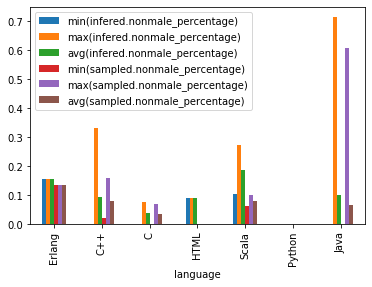

In [219]:
agg_by_language_local.plot.bar()

Promotion rates

In [220]:
committer_info_to_join = asf_agg_by_gender_and_proj_df.select(
    "project",
    F.expr("female + enby > 0").cast(LongType()).alias("has_female_or_enby_committer_magic"),
    F.col("nonmale_percentage").alias("nonmale_committer_percentage_magic"))

In [221]:
joined_with_commiter_info = joined_sampled_and_infered.join(
    committer_info_to_join,
    on="project",
    how="full_outer")

In [222]:
joined_with_project_info = joined_with_commiter_info.join(
    project_human_cleaned_df,
    on="project",
    how="full_outer").join(
    agg_post_sentiment,
    on="project",
    how="full_outer")

In [228]:
project_promo_rates = joined_with_project_info.select(
    "project",
    F.col("infered.nonmale_percentage").alias("infered_nonmale_percentage"),
    F.col("sampled.nonmale_percentage").alias("sampled_nonmale_percentage"),
    joined_with_project_info.nonmale_committer_percentage_magic.alias("non_male_commiter_percent")).na.drop()

In [229]:
project_promo_rates_local = project_promo_rates.toPandas()

In [230]:
project_promo_rates_local = project_promo_rates_local.set_index("project")
project_promo_rates_local

,infered_nonmale_percentage,sampled_nonmale_percentage,non_male_commiter_percent
project,,,
geode,0.111111,0.121951,0.133333
trafficserver,0.148148,0.161290,0.105263
httpd,0.076923,0.071429,0.000000
carbondata,0.272727,0.100000,0.272727
accumulo,0.000000,0.000000,0.030303
wicket,0.230769,0.142857,0.000000
couchdb,0.157895,0.136364,0.266667
bigtop,0.090909,0.083333,0.000000
zeppelin,0.153846,0.000000,0.181818


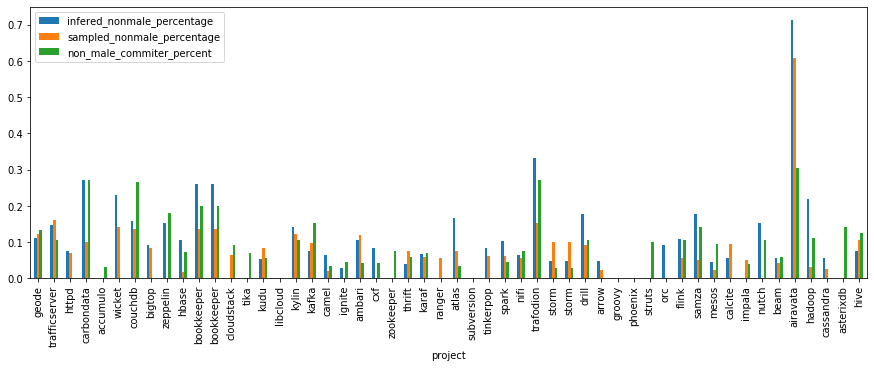

In [231]:
project_promo_rates_local.plot.bar(figsize=(15, 5))

By Project

In [ ]:
joined_with_project_info.show()

In [ ]:
joined_sampled_and_infered.show()

In [ ]:
basics_by_project = joined_sampled_and_infered.select(
    "project",
    F.col("infered.nonmale_percentage").alias("infered_nonmale"),
    F.col("sampled.nonmale_percentage").alias("sampled_nonmale")).na.drop()

In [ ]:
basics_by_project_local = basics_by_project.toPandas()

In [ ]:
basics_by_project_local = basics_by_project_local.set_index("project")

In [ ]:
basics_by_project_local

In [ ]:
basics_by_project_local.plot.bar(figsize=(15, 5))

In [ ]:
from itertools import chain

def flatmap(f, items):
        return chain.from_iterable(map(f, items))

def compute_new_columns(df):
    columns = df.columns
    def compute_numeric_columns(column):
        if "Answer_" in column and not "feedback" in column and not "_difficulty" in column:
            return [
                (~ F.isnull(F.col("`{0}`".format(column)))).cast("long").alias(column+"_exists"),
                (~ F.isnull(F.col("`{0}`".format(column))) & (F.col(column + "_difficulty") == "easy")).cast("long").alias(column+"_easy")]
        return []
    my_columns = list(flatmap(compute_numeric_columns, columns))
    my_columns.append("*")
    return df.select(*my_columns)

In [ ]:
numeric_df = compute_new_columns(joined_with_project_info)

In [ ]:
numeric_df.select("infered.nonmale_percentage")

In [ ]:
def care_about_column(column_name):
    c = column_name
    return "sentiment.pos" in c or "sentiment.neg" in c or \
           ("Answer_" in c and ("_exists" in c or "_easy" in c)) or "_magic" in c

aggs = [F.corr("sampled.nonmale_percentage", "infered.nonmale_percentage")]
computed_aggs = list(flatmap(
    lambda c: [F.corr("sampled.nonmale_percentage", "`{0}`".format(c)), F.corr("infered.nonmale_percentage", "`{0}`".format(c))],
    filter(care_about_column, sorted(numeric_df.columns))))
aggs.extend(computed_aggs)

In [ ]:
correlation_aggs_df = numeric_df.agg(*aggs).cache()

In [ ]:
correlation_aggs_df.show()

In [ ]:
local_cor = correlation_aggs_df.collect()

In [ ]:
local_cor

In [ ]:
corr_pandas_df = correlation_aggs_df.toPandas()

In [ ]:
corr_pandas_df.reindex(sorted(corr_pandas_df.columns), axis=1)

In [ ]:
corr_pandas_df_infered = corr_pandas_df.filter(regex="corr\(infered.*")
corr_pandas_df_sampled = corr_pandas_df.filter(regex="corr\(sampled.*")

In [ ]:
corr_pandas_df_infered.reindex(sorted(corr_pandas_df_infered.columns), axis=1)
corr_pandas_df_sampled.reindex(sorted(corr_pandas_df_sampled.columns), axis=1)

In [ ]:
corr_pandas_df_infered

In [ ]:
corr_pandas_df_infered.keys()

In [ ]:
import re
def parse_column_name_to_human(column):
    search = re.search(
        'corr\((infered|sampled)\.nonmale_percentage, `*(.*?)`*\)',
        column,
        re.IGNORECASE)

    if search:
        return search.group(2)
    return column

In [ ]:
parse_column_name_to_human("corr(infered.nonmale_percentage, `sentiment.pos_max`)")

In [ ]:
keys = list(map(parse_column_name_to_human, corr_pandas_df_infered.keys()))
plt.scatter(
    corr_pandas_df_infered.values,
    keys)

In [ ]:
corr_pandas_df_sampled

In [ ]:
import matplotlib.pyplot as plt
keys = list(map(parse_column_name_to_human, corr_pandas_df_sampled.keys()))
plt.scatter(
    corr_pandas_df_sampled.values,
    keys)

In [ ]:
cols = [col for col in corr_pandas_df_sampled if not col.endswith('nonmale_percentage)')] 
corr_features_only = corr_pandas_df_sampled[cols]
corr_features_only_t = corr_features_only.transpose()

In [ ]:
relevant = corr_features_only_t[(corr_features_only_t[0] > 0.2) | (corr_features_only_t[0] < -0.2)].transpose()

In [ ]:
keys = list(map(parse_column_name_to_human, relevant.keys()))
plt.scatter(
    relevant.values,
    keys)

In [ ]:
sentiment_cols = [col for col in relevant if 'sentiment' in col] 
relevant_sentiment = relevant[sentiment_cols]

In [ ]:
keys = list(map(parse_column_name_to_human, relevant_sentiment.keys()))
plt.scatter(
    relevant_sentiment.values,
    keys)

In [ ]:
non_sentiment_cols = [col for col in relevant if 'sentiment' not in col] 
relevant_remaining = relevant[non_sentiment_cols]

In [ ]:
keys = list(map(parse_column_name_to_human, relevant_remaining.keys()))
plt.scatter(
    relevant_remaining.values,
    keys)

In [ ]:
corr_infered_t = corr_pandas_df_infered.transpose()

In [ ]:
relevant_infered = corr_infered_t[(corr_infered_t[0] > 0.2) | \
                                  (corr_infered_t[0] < -0.2)].transpose()

In [ ]:
keys = list(map(parse_column_name_to_human, relevant_infered.keys()))
plt.scatter(
    relevant_infered.values,
    keys)

In [ ]:
# sc.stop()